# Computer Vision and Advanced Machine Learning area of the project.
### Author: Hugo Iglesias Pombo (2025)
### NO1: EDA and preprocessing of the datasets and U-Net

### Importations

Libraries

In [88]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import pandas as pd
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Configurar semillas para reproducibilidad
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Verificar dispositivos disponibles
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA disponible: {torch.cuda.is_available()}")
print(f"MPS (Metal) disponible: {torch.backends.mps.is_available()}")

# Seleccionar dispositivo óptimo (MPS para M4 Pro, CPU como fallback)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

PyTorch version: 2.5.1
CUDA disponible: False
MPS (Metal) disponible: True
Usando dispositivo: mps


In [89]:
import warnings
warnings.filterwarnings('ignore')

Datasets

In [90]:
dicom_data = pd.read_csv('/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/CBIS-DDSM/csv/dicom_info.csv')
image_dir = '/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/CBIS-DDSM/jpeg'

In [91]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [92]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [93]:
cropped_images = dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [94]:
cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images.head()

0     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
3     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
6     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
7     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
10    /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
Name: image_path, dtype: object

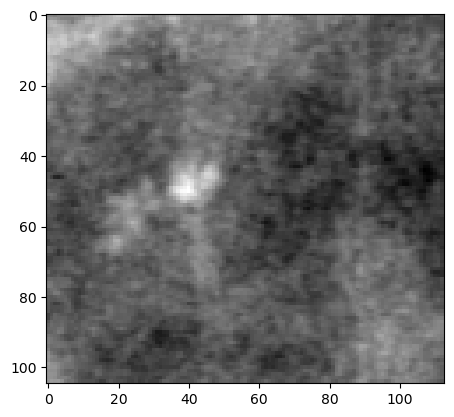

In [95]:
for file in cropped_images[0:10]:
    cropped_images_show = PIL.Image.open(file)
    gray_img= cropped_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [96]:
full_mammogram_images = dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [97]:
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images.head()

1     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
2     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
11    /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
12    /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
15    /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
Name: image_path, dtype: object

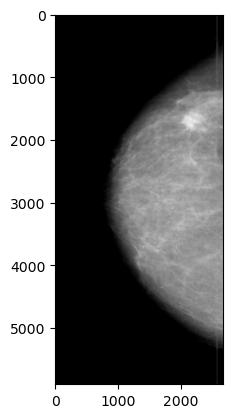

In [98]:
for file in full_mammogram_images[0:10]:
    full_mammogram_images_show = PIL.Image.open(file)
    gray_img = full_mammogram_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [99]:
ROI_mask_images = dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [100]:
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images.head()

5     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
8     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
9     /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
14    /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
20    /Volumes/Proyecto_Hugo/breast-cancer-analysis/...
Name: image_path, dtype: object

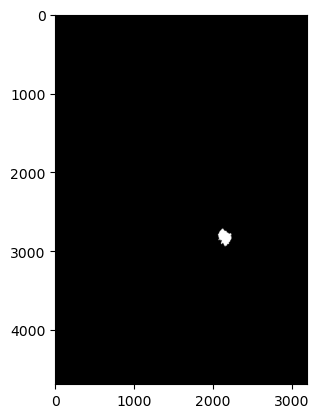

In [101]:
for file in ROI_mask_images[0:10]:
    ROI_mask_images_show = PIL.Image.open(file)
    gray_img = ROI_mask_images_show.convert("L")
    plt.imshow(gray_img, cmap='gray')

In [102]:
calc_case_df = pd.read_csv('/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/CBIS-DDSM/csv/calc_case_description_train_set.csv')

In [103]:
calc_case_df.head(5)

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [104]:
mass_case_df = pd.read_csv('/Volumes/Proyecto_Hugo/breast-cancer-analysis/datasets/CBIS-DDSM/csv/mass_case_description_train_set.csv')

In [105]:
mass_case_df.head(5)

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [106]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [107]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime','PatientSex','PatientBirthDate',
                                                'ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                                                'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'],axis =1, inplace=True)

In [108]:
dicom_cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   file_path                                    10237 non-null  object
 1   image_path                                   10237 non-null  object
 2   BitsAllocated                                10237 non-null  int64 
 3   BitsStored                                   10237 non-null  int64 
 4   BodyPartExamined                             10237 non-null  object
 5   ConversionType                               10237 non-null  object
 6   HighBit                                      10237 non-null  int64 
 7   LargestImagePixelValue                       10237 non-null  int64 
 8   Laterality                                   9671 non-null   object
 9   Modality                                     10237 non-null  object
 10  PatientID 

In [109]:
dicom_cleaned_data.isna().sum()

file_path                                        0
image_path                                       0
BitsAllocated                                    0
BitsStored                                       0
BodyPartExamined                                 0
ConversionType                                   0
HighBit                                          0
LargestImagePixelValue                           0
Laterality                                     566
Modality                                         0
PatientID                                        0
PatientName                                      0
PatientOrientation                               0
PhotometricInterpretation                        0
PixelRepresentation                              0
SamplesPerPixel                                  0
SecondaryCaptureDeviceManufacturer               0
SecondaryCaptureDeviceManufacturerModelName      0
SeriesDescription                              566
SmallestImagePixelValue        

In [110]:
dicom_cleaned_data['SeriesDescription'].fillna(method = 'bfill', axis = 0, inplace=True)

In [111]:
dicom_cleaned_data['Laterality'].fillna(method = 'bfill', axis = 0, inplace=True)

In [112]:
dicom_cleaned_data.isna().sum()

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [113]:
Data_cleaning_1 = calc_case_df.copy()
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')
Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [114]:
Data_cleaning_1['calc_type'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_1['calc_distribution'].fillna(method = 'bfill', axis = 0, inplace=True)
Data_cleaning_1.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [115]:
Data_cleaning_2 = mass_case_df.copy()
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()


patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [116]:
Data_cleaning_2['mass_shape'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True) 
Data_cleaning_2.isna().sum()

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [117]:
def load_and_preprocess(image_path, mask_path, img_size=(INPUT_SIZE, INPUT_SIZE)):
    """Carga y preprocesa una imagen y su máscara."""
    try:
        # Cargar imagen y máscara en escala de grises
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None or mask is None:
            print(f"Error: No se pudo cargar la imagen {image_path} o la máscara {mask_path}")
            # Crear imagen y máscara vacías como fallback
            image = np.zeros(img_size, dtype=np.uint8)
            mask = np.zeros(img_size, dtype=np.uint8)
        
        # Redimensionar
        image = cv2.resize(image, img_size)
        mask = cv2.resize(mask, img_size)
        
        # Normalizar imagen a [0,1]
        image = image / 255.0
        
        # Binarizar máscara
        mask = (mask > 0).astype(np.float32)
        
        return image, mask
    except Exception as e:
        print(f"Error al cargar/procesar imagen {image_path}: {e}")
        # Retornar imágenes vacías en caso de error
        return np.zeros(img_size, dtype=np.float32), np.zeros(img_size, dtype=np.float32)

In [118]:
def data_generator(image_mask_pairs, batch_size=8, img_size=(256, 256)):
    num_samples = len(image_mask_pairs)
    while True:
        # Mezclar al inicio de cada época
        random.shuffle(image_mask_pairs)
        
        for offset in range(0, num_samples, batch_size):
            batch_pairs = image_mask_pairs[offset:offset+batch_size]
            
            images = []
            masks = []
            
            for img_path, mask_path in batch_pairs:
                img, msk = load_and_preprocess(img_path, mask_path, img_size)
                images.append(img)
                masks.append(msk)
                
            yield np.array(images)[..., np.newaxis], np.array(masks)[..., np.newaxis]

# Crear generadores
train_gen = data_generator(train_pairs, batch_size=4)
val_gen = data_generator(val_pairs, batch_size=4)
test_gen = data_generator(test_pairs, batch_size=4)

Imágenes de entrenamiento: 2272
Imágenes de validación: 653
Imágenes de prueba: 322


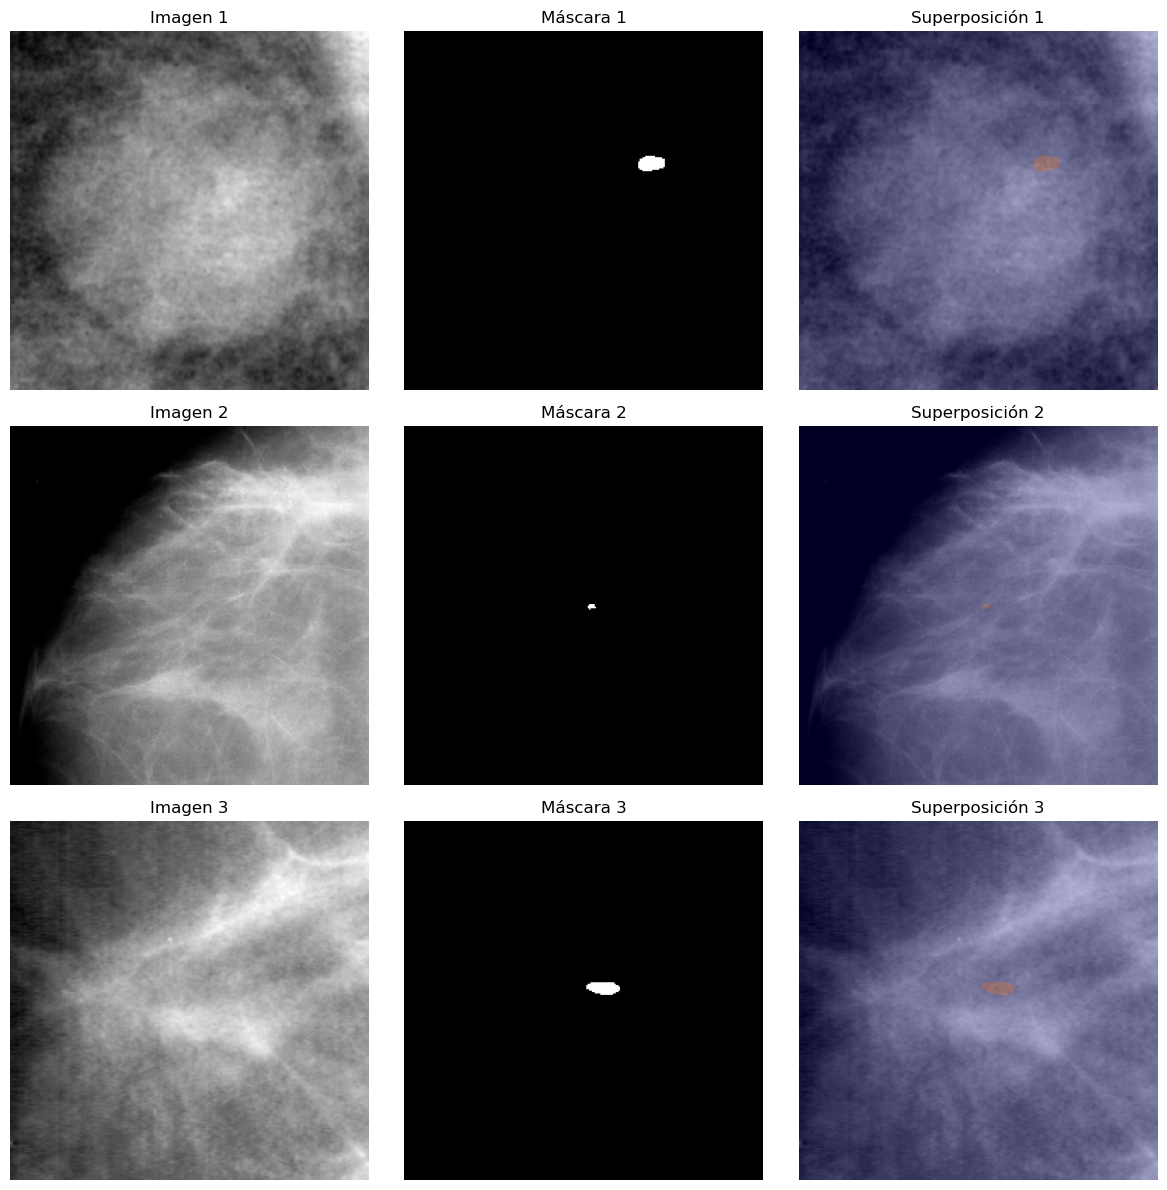

In [119]:
# Parámetros de configuración
IMG_SIZE = 256  # Puedes ajustar a 128 para inicio más rápido
BATCH_SIZE = 8
NUM_EPOCHS = 50
LEARNING_RATE = 1e-4

# Dataset personalizado
class MammogramDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size=IMG_SIZE, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Cargar imagen
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        # Redimensionar
        image = cv2.resize(image, (self.img_size, self.img_size))
        mask = cv2.resize(mask, (self.img_size, self.img_size))
        
        # Normalizar y aplicar umbral
        image = image / 255.0
        mask = (mask > 0).astype(np.float32)
        
        # Convertir a tensor
        image = torch.from_numpy(image).float().unsqueeze(0)  # Añadir dimensión de canal
        mask = torch.from_numpy(mask).float().unsqueeze(0)
        
        # Aplicar transformaciones si existen
        if self.transform:
            image = self.transform(image)
            
        return image, mask

# Preparar pares de imágenes y dividirlos en train/val/test
image_mask_pairs = list(zip(cropped_images, ROI_mask_images))

# División de datos
train_pairs, val_test_pairs = train_test_split(image_mask_pairs, test_size=0.3, random_state=42)
val_pairs, test_pairs = train_test_split(val_test_pairs, test_size=0.33, random_state=42)

# Extraer listas separadas de imágenes y máscaras
train_imgs, train_masks = zip(*train_pairs)
val_imgs, val_masks = zip(*val_pairs)
test_imgs, test_masks = zip(*test_pairs)

print(f"Imágenes de entrenamiento: {len(train_imgs)}")
print(f"Imágenes de validación: {len(val_imgs)}")
print(f"Imágenes de prueba: {len(test_imgs)}")

# Crear datasets
train_dataset = MammogramDataset(train_imgs, train_masks)
val_dataset = MammogramDataset(val_imgs, val_masks)
test_dataset = MammogramDataset(test_imgs, test_masks)

# Crear dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Visualizar algunas imágenes para verificar
def show_dataset_examples(dataset, num_examples=3):
    plt.figure(figsize=(12, 4*num_examples))
    
    for i in range(num_examples):
        idx = random.randint(0, len(dataset)-1)
        image, mask = dataset[idx]
        
        # Convertir a numpy para visualización
        image_np = image.squeeze().numpy()
        mask_np = mask.squeeze().numpy()
        
        plt.subplot(num_examples, 3, i*3+1)
        plt.imshow(image_np, cmap='gray')
        plt.title(f'Imagen {i+1}')
        plt.axis('off')
        
        plt.subplot(num_examples, 3, i*3+2)
        plt.imshow(mask_np, cmap='gray')
        plt.title(f'Máscara {i+1}')
        plt.axis('off')
        
        plt.subplot(num_examples, 3, i*3+3)
        plt.imshow(image_np, cmap='gray')
        plt.imshow(mask_np, cmap='jet', alpha=0.3)
        plt.title(f'Superposición {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualizar ejemplos
show_dataset_examples(train_dataset)

In [120]:
# Bloques básicos para U-Net
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # Redimensionar x1 si es necesario
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                         diffY // 2, diffY - diffY // 2])
        
        # Concatenar
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

# Modelo U-Net completo
class UNet(nn.Module):
    def __init__(self, n_channels=1, n_classes=1, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # Encoder (camino de contracción)
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        
        # Decoder (camino de expansión)
        self.up1 = Up(1024, 512 // factor)
        self.up2 = Up(512, 256 // factor)
        self.up3 = Up(256, 128 // factor)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        # Decoder con skip connections
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        
        # Activación sigmoid para segmentación binaria
        return self.sigmoid(logits)

# Inicializar el modelo
model = UNet(n_channels=1, n_classes=1)
model = model.to(device)
print(f"Modelo inicializado con {sum(p.numel() for p in model.parameters())} parámetros")

Modelo inicializado con 31036481 parámetros


In [121]:
# Coeficiente Dice como métrica
def dice_coef(pred, target, smooth=1.0):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)
    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

# Pérdida Dice
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, pred, target):
        return 1 - dice_coef(pred, target, self.smooth)

# Pérdida combinada (BCE + Dice)
class BCEDiceLoss(nn.Module):
    def __init__(self, weight_bce=0.5, weight_dice=0.5):
        super(BCEDiceLoss, self).__init__()
        self.weight_bce = weight_bce
        self.weight_dice = weight_dice
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        
    def forward(self, pred, target):
        return self.weight_bce * self.bce(pred, target) + self.weight_dice * self.dice(pred, target)

# Inicializar criterio y optimizador
criterion = BCEDiceLoss(weight_bce=0.5, weight_dice=0.5)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=5, factor=0.5, verbose=True)

In [122]:
# Función de entrenamiento
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS):
    best_dice = 0.0
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Entrenamiento
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        
        for inputs, targets in tqdm(train_loader, desc='Entrenamiento'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Poner a cero los gradientes
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            # Estadísticas
            train_loss += loss.item() * inputs.size(0)
            train_dice += dice_coef(outputs, targets).item() * inputs.size(0)
        
        train_loss = train_loss / len(train_loader.dataset)
        train_dice = train_dice / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        
        # Validación
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc='Validación'):
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                val_loss += loss.item() * inputs.size(0)
                val_dice += dice_coef(outputs, targets).item() * inputs.size(0)
        
        val_loss = val_loss / len(val_loader.dataset)
        val_dice = val_dice / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        
        # Actualizar scheduler
        scheduler.step(val_dice)
        
        # Guardar mejor modelo
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'best_unet_model.pth')
            print(f'¡Guardando mejor modelo con Dice {best_dice:.4f}!')
        
        print(f'Entrenamiento - Pérdida: {train_loss:.4f}, Dice: {train_dice:.4f}')
        print(f'Validación - Pérdida: {val_loss:.4f}, Dice: {val_dice:.4f}')
    
    # Cargar mejor modelo
    model.load_state_dict(torch.load('best_unet_model.pth'))
    
    return model, {'train_loss': train_losses, 'val_loss': val_losses, 
                  'train_dice': train_dices, 'val_dice': val_dices}

# Entrenar modelo
print("Iniciando entrenamiento...")
trained_model, history = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler)
print("¡Entrenamiento completado!")

Iniciando entrenamiento...
Epoch 1/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.62it/s]


¡Guardando mejor modelo con Dice 0.0185!
Entrenamiento - Pérdida: 0.6560, Dice: 0.0175
Validación - Pérdida: 0.6165, Dice: 0.0185
Epoch 2/50
----------


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.86it/s]


Entrenamiento - Pérdida: 0.5915, Dice: 0.0172
Validación - Pérdida: 0.5761, Dice: 0.0180
Epoch 3/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]


Entrenamiento - Pérdida: 0.5644, Dice: 0.0168
Validación - Pérdida: 0.5540, Dice: 0.0173
Epoch 4/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.67it/s]


Entrenamiento - Pérdida: 0.5477, Dice: 0.0163
Validación - Pérdida: 0.5413, Dice: 0.0168
Epoch 5/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.67it/s]


Entrenamiento - Pérdida: 0.5375, Dice: 0.0156
Validación - Pérdida: 0.5347, Dice: 0.0169
Epoch 6/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]


Entrenamiento - Pérdida: 0.5310, Dice: 0.0157
Validación - Pérdida: 0.5288, Dice: 0.0182
Epoch 7/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]


¡Guardando mejor modelo con Dice 0.0214!
Entrenamiento - Pérdida: 0.5257, Dice: 0.0184
Validación - Pérdida: 0.5227, Dice: 0.0214
Epoch 8/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]


Entrenamiento - Pérdida: 0.5223, Dice: 0.0196
Validación - Pérdida: 0.5205, Dice: 0.0210
Epoch 9/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]


Entrenamiento - Pérdida: 0.5199, Dice: 0.0208
Validación - Pérdida: 0.5190, Dice: 0.0195
Epoch 10/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]


¡Guardando mejor modelo con Dice 0.0229!
Entrenamiento - Pérdida: 0.5178, Dice: 0.0225
Validación - Pérdida: 0.5180, Dice: 0.0229
Epoch 11/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]


¡Guardando mejor modelo con Dice 0.0255!
Entrenamiento - Pérdida: 0.5173, Dice: 0.0219
Validación - Pérdida: 0.5187, Dice: 0.0255
Epoch 12/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.77it/s]


¡Guardando mejor modelo con Dice 0.0266!
Entrenamiento - Pérdida: 0.5162, Dice: 0.0228
Validación - Pérdida: 0.5178, Dice: 0.0266
Epoch 13/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.69it/s]


Entrenamiento - Pérdida: 0.5160, Dice: 0.0224
Validación - Pérdida: 0.5165, Dice: 0.0249
Epoch 14/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.79it/s]


Entrenamiento - Pérdida: 0.5152, Dice: 0.0234
Validación - Pérdida: 0.5156, Dice: 0.0232
Epoch 15/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]


Entrenamiento - Pérdida: 0.5154, Dice: 0.0226
Validación - Pérdida: 0.5158, Dice: 0.0236
Epoch 16/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.64it/s]


Entrenamiento - Pérdida: 0.5146, Dice: 0.0242
Validación - Pérdida: 0.5155, Dice: 0.0242
Epoch 17/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]


Entrenamiento - Pérdida: 0.5146, Dice: 0.0242
Validación - Pérdida: 0.5165, Dice: 0.0214
Epoch 18/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.64it/s]


Entrenamiento - Pérdida: 0.5144, Dice: 0.0238
Validación - Pérdida: 0.5149, Dice: 0.0246
Epoch 19/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]


Entrenamiento - Pérdida: 0.5136, Dice: 0.0255
Validación - Pérdida: 0.5148, Dice: 0.0245
Epoch 20/50
----------


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.85it/s]


Entrenamiento - Pérdida: 0.5136, Dice: 0.0255
Validación - Pérdida: 0.5145, Dice: 0.0263
Epoch 21/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.75it/s]


¡Guardando mejor modelo con Dice 0.0291!
Entrenamiento - Pérdida: 0.5134, Dice: 0.0267
Validación - Pérdida: 0.5141, Dice: 0.0291
Epoch 22/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.75it/s]


Entrenamiento - Pérdida: 0.5133, Dice: 0.0262
Validación - Pérdida: 0.5141, Dice: 0.0254
Epoch 23/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.67it/s]


Entrenamiento - Pérdida: 0.5130, Dice: 0.0279
Validación - Pérdida: 0.5138, Dice: 0.0264
Epoch 24/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.61it/s]


Entrenamiento - Pérdida: 0.5128, Dice: 0.0273
Validación - Pérdida: 0.5143, Dice: 0.0272
Epoch 25/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.76it/s]


Entrenamiento - Pérdida: 0.5126, Dice: 0.0281
Validación - Pérdida: 0.5144, Dice: 0.0274
Epoch 26/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.75it/s]


Entrenamiento - Pérdida: 0.5126, Dice: 0.0284
Validación - Pérdida: 0.5139, Dice: 0.0265
Epoch 27/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.70it/s]


Entrenamiento - Pérdida: 0.5127, Dice: 0.0277
Validación - Pérdida: 0.5137, Dice: 0.0282
Epoch 28/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.60it/s]


Entrenamiento - Pérdida: 0.5121, Dice: 0.0286
Validación - Pérdida: 0.5139, Dice: 0.0289
Epoch 29/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]


Entrenamiento - Pérdida: 0.5125, Dice: 0.0284
Validación - Pérdida: 0.5136, Dice: 0.0288
Epoch 30/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]


¡Guardando mejor modelo con Dice 0.0299!
Entrenamiento - Pérdida: 0.5121, Dice: 0.0288
Validación - Pérdida: 0.5137, Dice: 0.0299
Epoch 31/50
----------


Validación: 100%|██████████| 82/82 [00:18<00:00,  4.52it/s]


Entrenamiento - Pérdida: 0.5123, Dice: 0.0292
Validación - Pérdida: 0.5138, Dice: 0.0278
Epoch 32/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]


¡Guardando mejor modelo con Dice 0.0314!
Entrenamiento - Pérdida: 0.5122, Dice: 0.0288
Validación - Pérdida: 0.5141, Dice: 0.0314
Epoch 33/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]


Entrenamiento - Pérdida: 0.5117, Dice: 0.0307
Validación - Pérdida: 0.5142, Dice: 0.0270
Epoch 34/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]


Entrenamiento - Pérdida: 0.5114, Dice: 0.0312
Validación - Pérdida: 0.5161, Dice: 0.0258
Epoch 35/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]


Entrenamiento - Pérdida: 0.5118, Dice: 0.0305
Validación - Pérdida: 0.5143, Dice: 0.0288
Epoch 36/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]


Entrenamiento - Pérdida: 0.5111, Dice: 0.0320
Validación - Pérdida: 0.5151, Dice: 0.0278
Epoch 37/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]


¡Guardando mejor modelo con Dice 0.0328!
Entrenamiento - Pérdida: 0.5115, Dice: 0.0311
Validación - Pérdida: 0.5154, Dice: 0.0328
Epoch 38/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]


Entrenamiento - Pérdida: 0.5116, Dice: 0.0311
Validación - Pérdida: 0.5149, Dice: 0.0313
Epoch 39/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]


Entrenamiento - Pérdida: 0.5117, Dice: 0.0313
Validación - Pérdida: 0.5139, Dice: 0.0299
Epoch 40/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]


Entrenamiento - Pérdida: 0.5106, Dice: 0.0332
Validación - Pérdida: 0.5152, Dice: 0.0292
Epoch 41/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]


Entrenamiento - Pérdida: 0.5109, Dice: 0.0333
Validación - Pérdida: 0.5150, Dice: 0.0265
Epoch 42/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]


Entrenamiento - Pérdida: 0.5103, Dice: 0.0338
Validación - Pérdida: 0.5158, Dice: 0.0284
Epoch 43/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]


Entrenamiento - Pérdida: 0.5111, Dice: 0.0335
Validación - Pérdida: 0.5149, Dice: 0.0271
Epoch 44/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.60it/s]


Entrenamiento - Pérdida: 0.5105, Dice: 0.0335
Validación - Pérdida: 0.5151, Dice: 0.0268
Epoch 45/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.59it/s]


Entrenamiento - Pérdida: 0.5085, Dice: 0.0382
Validación - Pérdida: 0.5153, Dice: 0.0288
Epoch 46/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.57it/s]


Entrenamiento - Pérdida: 0.5086, Dice: 0.0387
Validación - Pérdida: 0.5151, Dice: 0.0277
Epoch 47/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]


Entrenamiento - Pérdida: 0.5082, Dice: 0.0392
Validación - Pérdida: 0.5154, Dice: 0.0282
Epoch 48/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]


Entrenamiento - Pérdida: 0.5076, Dice: 0.0395
Validación - Pérdida: 0.5162, Dice: 0.0313
Epoch 49/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.58it/s]


Entrenamiento - Pérdida: 0.5085, Dice: 0.0387
Validación - Pérdida: 0.5163, Dice: 0.0281
Epoch 50/50
----------


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.60it/s]


Entrenamiento - Pérdida: 0.5067, Dice: 0.0420
Validación - Pérdida: 0.5158, Dice: 0.0280
¡Entrenamiento completado!


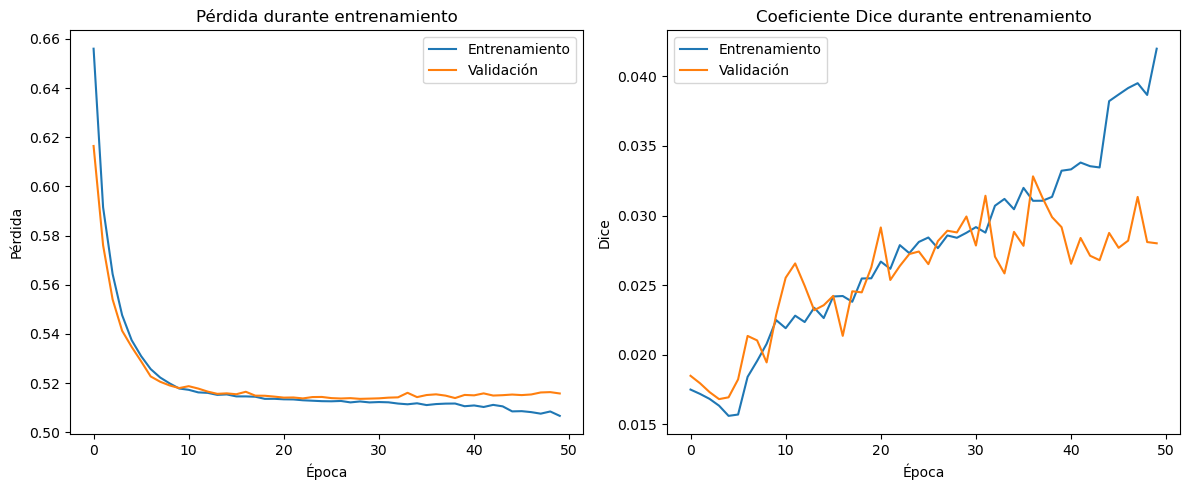

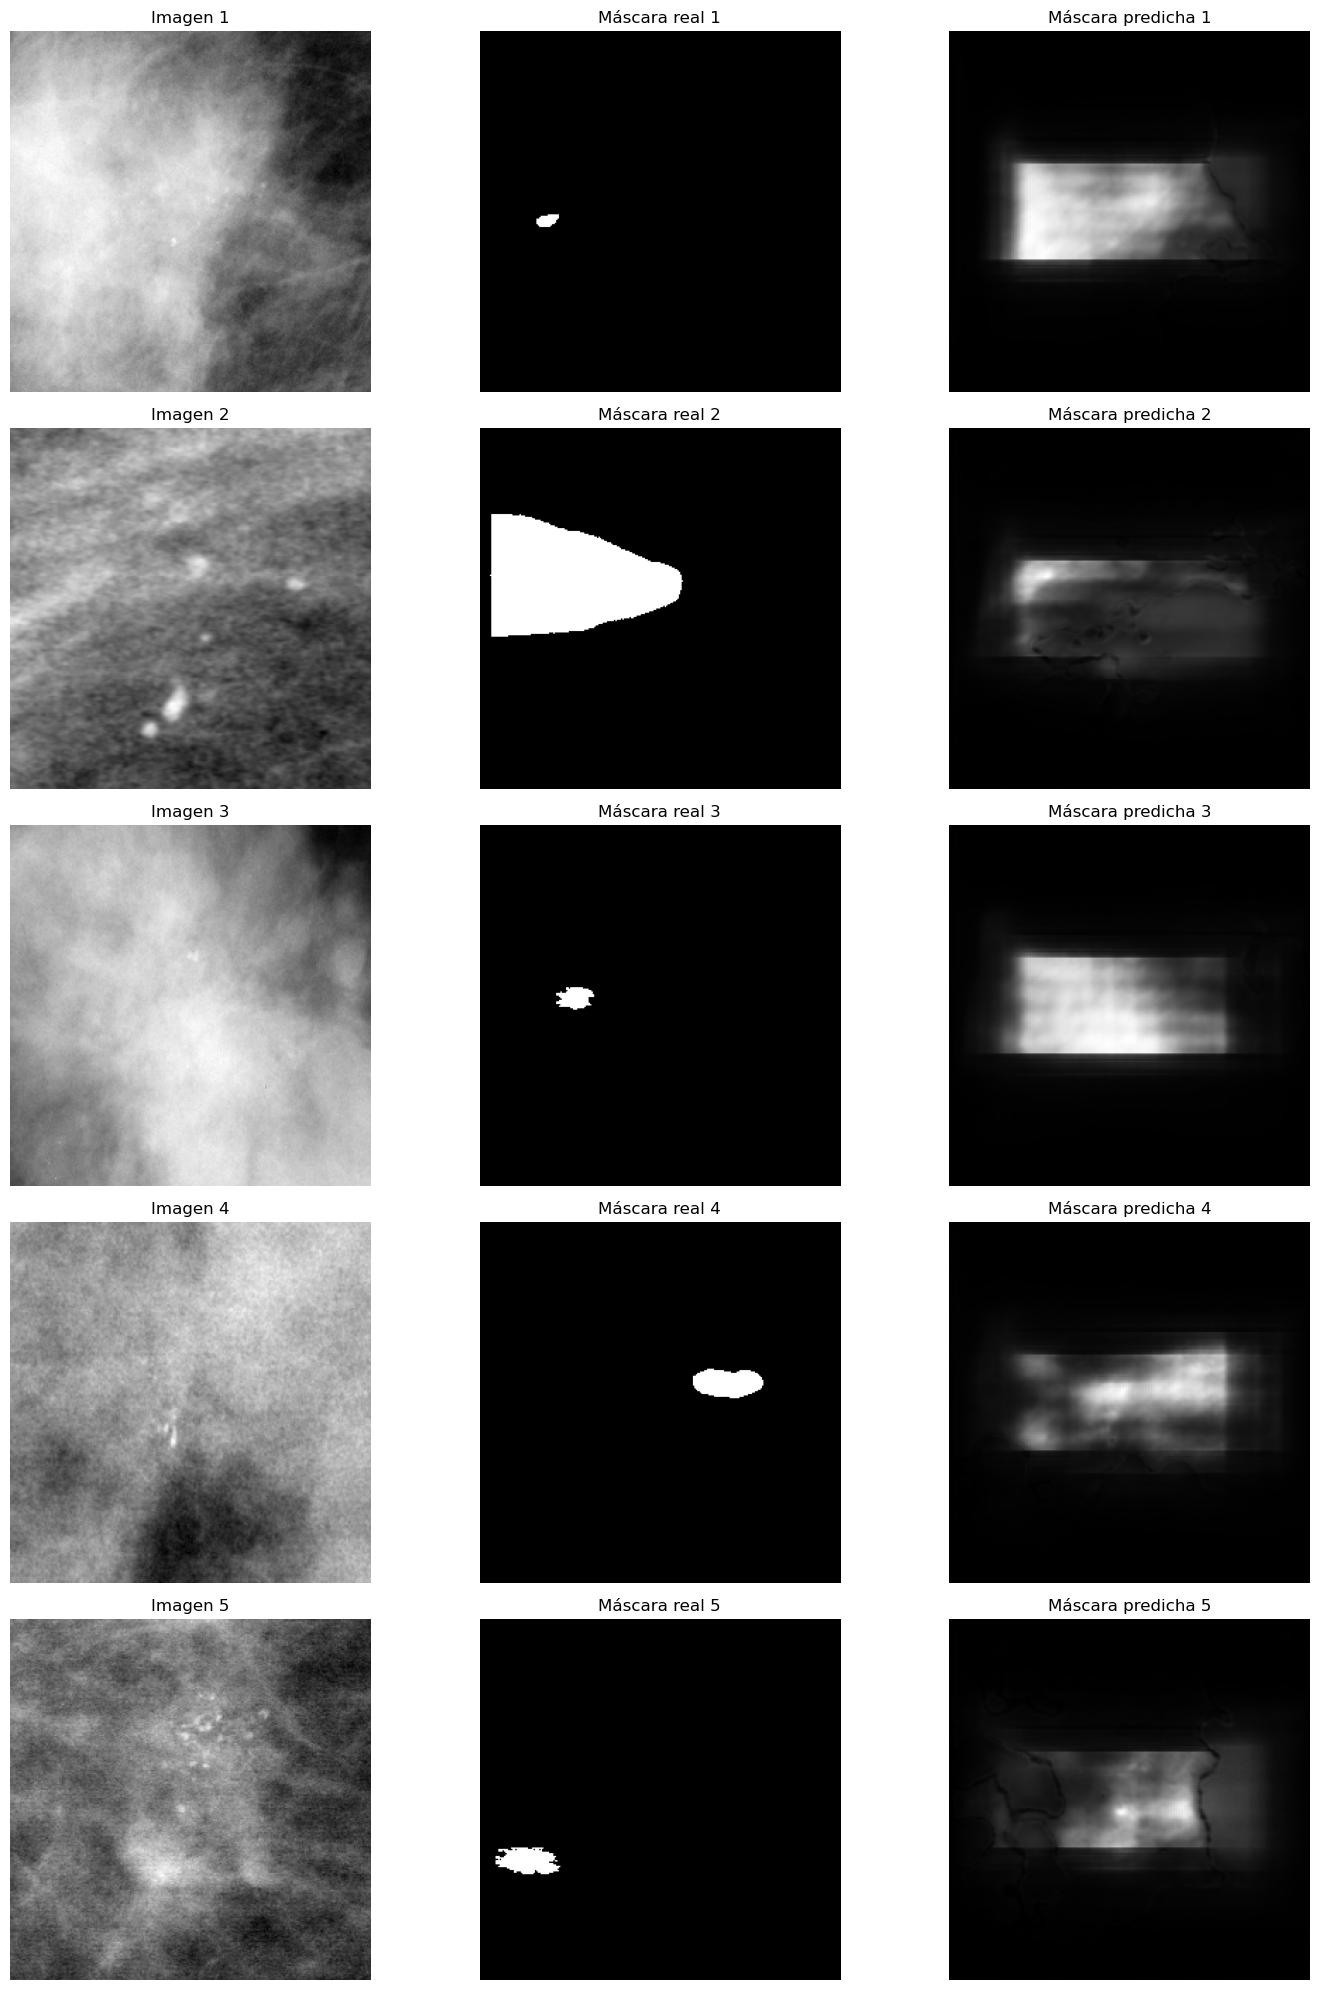

In [123]:
# Visualizar historia del entrenamiento
def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    
    # Pérdida
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Entrenamiento')
    plt.plot(history['val_loss'], label='Validación')
    plt.title('Pérdida durante entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Pérdida')
    plt.legend()
    
    # Dice
    plt.subplot(1, 2, 2)
    plt.plot(history['train_dice'], label='Entrenamiento')
    plt.plot(history['val_dice'], label='Validación')
    plt.title('Coeficiente Dice durante entrenamiento')
    plt.xlabel('Época')
    plt.ylabel('Dice')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

# Visualizar predicciones
def visualize_predictions(model, test_dataset, num_samples=5):
    model.eval()
    plt.figure(figsize=(15, 4*num_samples))
    
    indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, true_mask = test_dataset[idx]
        
        # Añadir dimensión de batch y mover a dispositivo
        image = image.unsqueeze(0).to(device)
        
        # Predecir
        with torch.no_grad():
            pred_mask = model(image)
        
        # Convertir a numpy para visualizar
        image = image.squeeze().cpu().numpy()
        true_mask = true_mask.squeeze().cpu().numpy()
        pred_mask = pred_mask.squeeze().cpu().numpy()
        
        # Visualizar resultados
        plt.subplot(num_samples, 3, i*3+1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Imagen {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+2)
        plt.imshow(true_mask, cmap='gray')
        plt.title(f'Máscara real {i+1}')
        plt.axis('off')
        
        plt.subplot(num_samples, 3, i*3+3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title(f'Máscara predicha {i+1}')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('predictions.png')
    plt.show()

# Visualizar historia del entrenamiento
plot_training_history(history)

# Visualizar predicciones
visualize_predictions(trained_model, test_dataset)

In [124]:
# Evaluar en conjunto de prueba
def evaluate_model(model, test_loader):
    model.eval()
    test_dice = 0.0
    
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc='Evaluación'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            outputs = model(inputs)
            test_dice += dice_coef(outputs, targets).item() * inputs.size(0)
    
    test_dice = test_dice / len(test_loader.dataset)
    print(f'Evaluación final en conjunto de prueba - Coeficiente Dice: {test_dice:.4f}')
    return test_dice

# Evaluar el modelo
final_dice = evaluate_model(trained_model, test_loader)

Evaluación: 100%|██████████| 41/41 [00:08<00:00,  4.64it/s]

Evaluación final en conjunto de prueba - Coeficiente Dice: 0.0350


In [125]:
# Guardar el modelo final
torch.save({
    'model_state_dict': trained_model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_dice': final_dice
}, 'unet_mamografia_final.pth')

print("Modelo guardado correctamente como 'unet_mamografia_final.pth'")

# Función para cargar el modelo (para uso futuro)
def load_model(model_path, model_class=UNet):
    # Inicializar modelo
    model = model_class(n_channels=1, n_classes=1)
    
    # Cargar pesos
    checkpoint = torch.load(model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    
    return model

# Ejemplo de carga
# loaded_model = load_model('unet_mamografia_final.pth')

Modelo guardado correctamente como 'unet_mamografia_final.pth'


In [126]:
# Reemplazo la función de pérdida actual con esta implementación mejorada
class FocalDiceLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.0, dice_weight=0.6):
        super(FocalDiceLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.dice_weight = dice_weight
        self.smooth = 1.0
        
    def forward(self, pred, target):
        # Implementación de Focal Loss para el desequilibrio de clases
        bce = F.binary_cross_entropy(pred, target, reduction='none')
        
        # Parte focal: da más peso a los ejemplos difíciles
        pt = torch.exp(-bce)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce
        focal_loss = focal_loss.mean()
        
        # Parte Dice: enfocada en la superposición
        pred_flat = pred.view(-1)
        target_flat = target.view(-1)
        intersection = (pred_flat * target_flat).sum()
        union = pred_flat.sum() + target_flat.sum()
        
        dice_loss = 1 - (2. * intersection + self.smooth) / (union + self.smooth)
        
        # Combinación ponderada
        return (1 - self.dice_weight) * focal_loss + self.dice_weight * dice_loss

# Reemplaza la definición de tu criterion con esta
criterion = FocalDiceLoss(alpha=0.75, gamma=2.0, dice_weight=0.6)

In [132]:
# Reemplazo el Dataset existente con esta implementación mejorada
class EnhancedMammogramDataset(Dataset):
    def __init__(self, image_paths, mask_paths, img_size=256, is_train=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.img_size = img_size
        self.is_train = is_train  # Para aplicar aumentación solo en training
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
        
        # Cargar imagen
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None or mask is None:
            # Falback si alguna imagen es inválida
            image = np.zeros((self.img_size, self.img_size), dtype=np.float32)
            mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        else:
            # Redimensionar
            image = cv2.resize(image, (self.img_size, self.img_size))
            mask = cv2.resize(mask, (self.img_size, self.img_size))
            
            # Normalizar y umbralizar
            image = image / 255.0
            mask = (mask > 0).astype(np.float32)
            
            # Aplicar aumentación solo durante entrenamiento
            if self.is_train:
                # Volteo horizontal (50% prob)
                if random.random() > 0.5:
                    image = np.fliplr(image)
                    mask = np.fliplr(mask)
                
                # Volteo vertical (50% prob)
                if random.random() > 0.5:
                    image = np.flipud(image)
                    mask = np.flipud(mask)
                
                # Rotación (25% para cada ángulo de 90°)
                k = random.randint(0, 3)
                if k > 0:
                    image = np.rot90(image, k)
                    mask = np.rot90(mask, k)
                
                # Ajustes de contraste (75% prob)
                if random.random() > 0.25:
                    gamma = random.uniform(0.8, 1.2)
                    image = np.clip(np.power(image, gamma), 0, 1)
                
                # Zoom en regiones con lesiones (30% prob)
                if random.random() > 0.7 and np.sum(mask) > 0:
                    # Encontrar coordenadas de la lesión
                    y, x = np.where(mask > 0)
                    cy, cx = int(np.mean(y)), int(np.mean(x))
                    
                    # Calcular tamaño de recorte
                    zoom_factor = random.uniform(0.6, 0.9)
                    crop_size = int(self.img_size * zoom_factor)
                    
                    # Asegurar que el centro de la lesión esté en el recorte
                    x1 = max(0, cx - crop_size//2)
                    y1 = max(0, cy - crop_size//2)
                    
                    # Ajustar para que no se salga de los límites
                    x1 = min(x1, self.img_size - crop_size)
                    y1 = min(y1, self.img_size - crop_size)
                    
                    # Recortar
                    image = image[y1:y1+crop_size, x1:x1+crop_size]
                    mask = mask[y1:y1+crop_size, x1:x1+crop_size]
                    
                    # Redimensionar al tamaño original
                    image = cv2.resize(image, (self.img_size, self.img_size))
                    mask = cv2.resize(mask, (self.img_size, self.img_size))
                    mask = (mask > 0.5).astype(np.float32)  # Re-binarizar
        
        # Convertir a tensor
        image = torch.from_numpy(image.copy()).float().unsqueeze(0)  # [1, H, W]
        mask = torch.from_numpy(mask.copy()).float().unsqueeze(0)   # [1, H, W]
        
        return image, mask

# Reemplaza tus dataloaders con estos nuevos
train_dataset = EnhancedMammogramDataset(train_imgs, train_masks, img_size=IMG_SIZE, is_train=True)
val_dataset = EnhancedMammogramDataset(val_imgs, val_masks, img_size=IMG_SIZE, is_train=False)
test_dataset = EnhancedMammogramDataset(test_imgs, test_masks, img_size=IMG_SIZE, is_train=False)

# Crear nuevos dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [128]:
# Reemplazo tu optimizador actual con este más agresivo al inicio
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

# Reemplazo el scheduler actual con este
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',           # Maximizar Dice
    factor=0.5,           # Reducir LR a la mitad
    patience=7,           # Esperar 7 épocas antes de reducir
    min_lr=1e-6,          # LR mínimo
    verbose=True          # Mostrar cambios
)

In [130]:
# Reemplazo la función de entrenamiento con esta versión mejorada
def train_model_enhanced(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=50):
    best_dice = 0.0
    train_losses = []
    val_losses = []
    train_dices = []
    val_dices = []
    
    # Variables para early stopping
    patience = 15  # Esperar 15 épocas sin mejora
    counter = 0
    early_stop = False
    
    # Para cada época
    for epoch in range(num_epochs):
        if early_stop:
            print("Early stopping triggered")
            break
            
        print(f'Época {epoch+1}/{num_epochs}')
        print('-' * 10)
        
        # Entrenamiento
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        train_batch_count = 0
        
        for inputs, targets in tqdm(train_loader, desc='Entrenamiento'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            # Calculo de pérdida
            loss = criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            
            # Clipping de gradientes para estabilidad
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            # Optimización
            optimizer.step()
            
            # Calcular Dice para este batch
            batch_dice = dice_coef(outputs, targets).item()
            
            # Acumular estadísticas
            train_loss += loss.item() * inputs.size(0)
            train_dice += batch_dice * inputs.size(0)
            train_batch_count += inputs.size(0)
            
            # Mostrar progreso cada 20 batches
            if train_batch_count % (20 * BATCH_SIZE) == 0:
                print(f"  Batch {train_batch_count//BATCH_SIZE}: Loss={loss.item():.4f}, Dice={batch_dice:.4f}")
        
        # Calcular promedios de entrenamiento
        train_loss = train_loss / len(train_loader.dataset)
        train_dice = train_dice / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_dices.append(train_dice)
        
        # Validación
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_batch_count = 0
        
        with torch.no_grad():
            for inputs, targets in tqdm(val_loader, desc='Validación'):
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                # Forward pass
                outputs = model(inputs)
                
                # Calculo de pérdida
                loss = criterion(outputs, targets)
                
                # Calcular Dice para este batch
                batch_dice = dice_coef(outputs, targets).item()
                
                # Acumular estadísticas
                val_loss += loss.item() * inputs.size(0)
                val_dice += batch_dice * inputs.size(0)
                val_batch_count += inputs.size(0)
        
        # Calcular promedios de validación
        val_loss = val_loss / len(val_loader.dataset)
        val_dice = val_dice / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_dices.append(val_dice)
        
        # Actualizar scheduler basado en Dice de validación
        scheduler.step(val_dice)
        
        # Imprimir resultados
        print(f'Entrenamiento - Pérdida: {train_loss:.4f}, Dice: {train_dice:.4f}')
        print(f'Validación - Pérdida: {val_loss:.4f}, Dice: {val_dice:.4f}')
        
        # Guardar mejor modelo
        if val_dice > best_dice:
            best_dice = val_dice
            torch.save(model.state_dict(), 'best_unet_mammogram.pth')
            print(f'¡Guardando mejor modelo con Dice {best_dice:.4f}!')
            counter = 0  # Reiniciar contador de early stopping
        else:
            counter += 1
            print(f'Dice no mejoró. Counter: {counter}/{patience}')
            
            if counter >= patience:
                early_stop = True
                print("Activando early stopping en la siguiente época")
    
    # Cargar el mejor modelo
    model.load_state_dict(torch.load('best_unet_mammogram.pth'))
    
    return model, {'train_loss': train_losses, 'val_loss': val_losses, 
                   'train_dice': train_dices, 'val_dice': val_dices}


Iniciando entrenamiento con configuración optimizada para mamografías...
Época 1/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:11<02:22,  1.85it/s]

  Batch 20: Loss=0.6045, Dice=0.0062


Entrenamiento:  14%|█▍        | 40/284 [00:22<02:09,  1.88it/s]

  Batch 40: Loss=0.5926, Dice=0.0265


Entrenamiento:  21%|██        | 60/284 [00:32<01:58,  1.88it/s]

  Batch 60: Loss=0.5884, Dice=0.0283


Entrenamiento:  28%|██▊       | 80/284 [00:43<01:49,  1.86it/s]

  Batch 80: Loss=0.5979, Dice=0.0209


Entrenamiento:  35%|███▌      | 100/284 [00:54<01:38,  1.86it/s]

  Batch 100: Loss=0.6107, Dice=0.0096


Entrenamiento:  42%|████▏     | 120/284 [01:04<01:26,  1.89it/s]

  Batch 120: Loss=0.6147, Dice=0.0113


Entrenamiento:  49%|████▉     | 140/284 [01:15<01:16,  1.87it/s]

  Batch 140: Loss=0.5932, Dice=0.0265


Entrenamiento:  56%|█████▋    | 160/284 [01:26<01:06,  1.85it/s]

  Batch 160: Loss=0.5980, Dice=0.0108


Entrenamiento:  63%|██████▎   | 180/284 [01:37<00:55,  1.86it/s]

  Batch 180: Loss=0.5981, Dice=0.0236


Entrenamiento:  70%|███████   | 200/284 [01:47<00:44,  1.88it/s]

  Batch 200: Loss=0.5696, Dice=0.0601


Entrenamiento:  77%|███████▋  | 220/284 [01:58<00:34,  1.85it/s]

  Batch 220: Loss=0.6041, Dice=0.0011


Entrenamiento:  85%|████████▍ | 240/284 [02:09<00:23,  1.85it/s]

  Batch 240: Loss=0.5920, Dice=0.0218


Entrenamiento:  92%|█████████▏| 260/284 [02:20<00:12,  1.86it/s]

  Batch 260: Loss=0.6003, Dice=0.0058


Entrenamiento:  99%|█████████▊| 280/284 [02:30<00:02,  1.86it/s]

  Batch 280: Loss=0.5988, Dice=0.0086


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.68it/s]


Entrenamiento - Pérdida: 0.5972, Dice: 0.0260
Validación - Pérdida: 0.5944, Dice: 0.0216
¡Guardando mejor modelo con Dice 0.0216!
Época 2/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:18,  1.90it/s]

  Batch 20: Loss=0.5852, Dice=0.0554


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:08,  1.90it/s]

  Batch 40: Loss=0.6002, Dice=0.0158


Entrenamiento:  21%|██        | 60/284 [00:31<02:02,  1.83it/s]

  Batch 60: Loss=0.6030, Dice=0.0336


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:50,  1.85it/s]

  Batch 80: Loss=0.5960, Dice=0.0154


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:38,  1.86it/s]

  Batch 100: Loss=0.6053, Dice=0.0161


Entrenamiento:  42%|████▏     | 120/284 [01:04<01:27,  1.88it/s]

  Batch 120: Loss=0.5959, Dice=0.0154


Entrenamiento:  49%|████▉     | 140/284 [01:14<01:15,  1.90it/s]

  Batch 140: Loss=0.6090, Dice=0.0174


Entrenamiento:  56%|█████▋    | 160/284 [01:25<01:08,  1.82it/s]

  Batch 160: Loss=0.5738, Dice=0.1738


Entrenamiento:  63%|██████▎   | 180/284 [01:35<00:54,  1.92it/s]

  Batch 180: Loss=0.6198, Dice=0.0617


Entrenamiento:  70%|███████   | 200/284 [01:46<00:44,  1.91it/s]

  Batch 200: Loss=0.6024, Dice=0.0114


Entrenamiento:  77%|███████▋  | 220/284 [01:56<00:34,  1.85it/s]

  Batch 220: Loss=0.5724, Dice=0.0609


Entrenamiento:  85%|████████▍ | 240/284 [02:07<00:23,  1.86it/s]

  Batch 240: Loss=0.5959, Dice=0.0252


Entrenamiento:  92%|█████████▏| 260/284 [02:18<00:12,  1.89it/s]

  Batch 260: Loss=0.5773, Dice=0.0478


Entrenamiento:  99%|█████████▊| 280/284 [02:28<00:02,  1.88it/s]

  Batch 280: Loss=0.6084, Dice=0.0106


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.87it/s]


Entrenamiento - Pérdida: 0.5943, Dice: 0.0304
Validación - Pérdida: 0.6127, Dice: 0.0279
¡Guardando mejor modelo con Dice 0.0279!
Época 3/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:20,  1.88it/s]

  Batch 20: Loss=0.6186, Dice=0.0022


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:11,  1.86it/s]

  Batch 40: Loss=0.5747, Dice=0.0703


Entrenamiento:  21%|██        | 60/284 [00:31<02:01,  1.85it/s]

  Batch 60: Loss=0.6009, Dice=0.0317


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:47,  1.90it/s]

  Batch 80: Loss=0.5830, Dice=0.0524


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:39,  1.85it/s]

  Batch 100: Loss=0.5994, Dice=0.0158


Entrenamiento:  42%|████▏     | 120/284 [01:03<01:25,  1.91it/s]

  Batch 120: Loss=0.5970, Dice=0.0317


Entrenamiento:  49%|████▉     | 140/284 [01:14<01:18,  1.83it/s]

  Batch 140: Loss=0.5964, Dice=0.0216


Entrenamiento:  56%|█████▋    | 160/284 [01:25<01:05,  1.91it/s]

  Batch 160: Loss=0.6189, Dice=0.0067


Entrenamiento:  63%|██████▎   | 180/284 [01:35<00:54,  1.91it/s]

  Batch 180: Loss=0.5974, Dice=0.0250


Entrenamiento:  70%|███████   | 200/284 [01:46<00:43,  1.92it/s]

  Batch 200: Loss=0.6022, Dice=0.0284


Entrenamiento:  77%|███████▋  | 220/284 [01:56<00:33,  1.90it/s]

  Batch 220: Loss=0.5673, Dice=0.0746


Entrenamiento:  85%|████████▍ | 240/284 [02:07<00:23,  1.90it/s]

  Batch 240: Loss=0.6004, Dice=0.0245


Entrenamiento:  92%|█████████▏| 260/284 [02:17<00:12,  1.91it/s]

  Batch 260: Loss=0.6195, Dice=0.0032


Entrenamiento:  99%|█████████▊| 280/284 [02:28<00:02,  1.91it/s]

  Batch 280: Loss=0.5982, Dice=0.0147


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.85it/s]


Entrenamiento - Pérdida: 0.5936, Dice: 0.0378
Validación - Pérdida: 0.5966, Dice: 0.0264
Dice no mejoró. Counter: 1/15
Época 4/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:18,  1.91it/s]

  Batch 20: Loss=0.6034, Dice=0.0166


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.6039, Dice=0.0167


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.92it/s]

  Batch 60: Loss=0.5664, Dice=0.0756


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:44,  1.95it/s]

  Batch 80: Loss=0.5565, Dice=0.0938


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:35,  1.92it/s]

  Batch 100: Loss=0.6128, Dice=0.0171


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:25,  1.93it/s]

  Batch 120: Loss=0.5678, Dice=0.0625


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.94it/s]

  Batch 140: Loss=0.6038, Dice=0.0128


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:03,  1.94it/s]

  Batch 160: Loss=0.6068, Dice=0.0033


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.95it/s]

  Batch 180: Loss=0.5796, Dice=0.0594


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.95it/s]

  Batch 200: Loss=0.5961, Dice=0.0211


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:32,  1.94it/s]

  Batch 220: Loss=0.6326, Dice=0.0031


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.93it/s]

  Batch 240: Loss=0.5927, Dice=0.0311


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.93it/s]

  Batch 260: Loss=0.6049, Dice=0.0184


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.92it/s]

  Batch 280: Loss=0.5962, Dice=0.0389


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]


Entrenamiento - Pérdida: 0.5961, Dice: 0.0345
Validación - Pérdida: 0.5956, Dice: 0.0255
Dice no mejoró. Counter: 2/15
Época 5/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:20,  1.87it/s]

  Batch 20: Loss=0.6038, Dice=0.0148


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.92it/s]

  Batch 40: Loss=0.6028, Dice=0.0103


Entrenamiento:  21%|██        | 60/284 [00:31<01:55,  1.94it/s]

  Batch 60: Loss=0.6143, Dice=0.0050


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:44,  1.95it/s]

  Batch 80: Loss=0.6021, Dice=0.0128


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:35,  1.92it/s]

  Batch 100: Loss=0.6043, Dice=0.0179


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:24,  1.95it/s]

  Batch 120: Loss=0.6012, Dice=0.0133


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.94it/s]

  Batch 140: Loss=0.6040, Dice=0.0160


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.92it/s]

  Batch 160: Loss=0.6102, Dice=0.0635


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:54,  1.92it/s]

  Batch 180: Loss=0.6034, Dice=0.0151


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.93it/s]

  Batch 200: Loss=0.6000, Dice=0.0342


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:32,  1.94it/s]

  Batch 220: Loss=0.6165, Dice=0.0068


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.94it/s]

  Batch 240: Loss=0.6153, Dice=0.0014


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.93it/s]

  Batch 260: Loss=0.6075, Dice=0.0105


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.93it/s]

  Batch 280: Loss=0.5949, Dice=0.0189


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.03it/s]


Entrenamiento - Pérdida: 0.5965, Dice: 0.0360
Validación - Pérdida: 0.6098, Dice: 0.0250
Dice no mejoró. Counter: 3/15
Época 6/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:16,  1.93it/s]

  Batch 20: Loss=0.6031, Dice=0.0166


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:07,  1.92it/s]

  Batch 40: Loss=0.6025, Dice=0.0184


Entrenamiento:  21%|██        | 60/284 [00:31<01:55,  1.94it/s]

  Batch 60: Loss=0.5969, Dice=0.0273


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:52,  1.82it/s]

  Batch 80: Loss=0.5643, Dice=0.0771


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:40,  1.83it/s]

  Batch 100: Loss=0.6060, Dice=0.0121


Entrenamiento:  42%|████▏     | 120/284 [01:04<01:31,  1.79it/s]

  Batch 120: Loss=0.5919, Dice=0.0623


Entrenamiento:  49%|████▉     | 140/284 [01:15<01:16,  1.88it/s]

  Batch 140: Loss=0.6054, Dice=0.0174


Entrenamiento:  56%|█████▋    | 160/284 [01:26<01:09,  1.79it/s]

  Batch 160: Loss=0.5839, Dice=0.0551


Entrenamiento:  63%|██████▎   | 180/284 [01:36<00:54,  1.90it/s]

  Batch 180: Loss=0.5792, Dice=0.0565


Entrenamiento:  70%|███████   | 200/284 [01:47<00:43,  1.92it/s]

  Batch 200: Loss=0.5895, Dice=0.0671


Entrenamiento:  77%|███████▋  | 220/284 [01:57<00:33,  1.92it/s]

  Batch 220: Loss=0.6074, Dice=0.0197


Entrenamiento:  85%|████████▍ | 240/284 [02:08<00:22,  1.93it/s]

  Batch 240: Loss=0.6063, Dice=0.0037


Entrenamiento:  92%|█████████▏| 260/284 [02:18<00:12,  1.92it/s]

  Batch 260: Loss=0.6166, Dice=0.0527


Entrenamiento:  99%|█████████▊| 280/284 [02:29<00:02,  1.91it/s]

  Batch 280: Loss=0.5574, Dice=0.0967


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]


Entrenamiento - Pérdida: 0.5918, Dice: 0.0388
Validación - Pérdida: 0.5893, Dice: 0.0363
¡Guardando mejor modelo con Dice 0.0363!
Época 7/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:16,  1.93it/s]

  Batch 20: Loss=0.6028, Dice=0.0078


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:05,  1.95it/s]

  Batch 40: Loss=0.6284, Dice=0.0149


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.93it/s]

  Batch 60: Loss=0.5972, Dice=0.0249


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.93it/s]

  Batch 80: Loss=0.6195, Dice=0.0135


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:33,  1.96it/s]

  Batch 100: Loss=0.6029, Dice=0.0412


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:24,  1.95it/s]

  Batch 120: Loss=0.6011, Dice=0.0223


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:15,  1.92it/s]

  Batch 140: Loss=0.5662, Dice=0.0756


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.92it/s]

  Batch 160: Loss=0.5903, Dice=0.0493


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.94it/s]

  Batch 180: Loss=0.6038, Dice=0.0151


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.92it/s]

  Batch 200: Loss=0.5978, Dice=0.0419


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:32,  1.95it/s]

  Batch 220: Loss=0.5855, Dice=0.0422


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.94it/s]

  Batch 240: Loss=0.5997, Dice=0.0148


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.92it/s]

  Batch 260: Loss=0.5949, Dice=0.0268


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.92it/s]

  Batch 280: Loss=0.6005, Dice=0.0250


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.03it/s]


Entrenamiento - Pérdida: 0.5934, Dice: 0.0412
Validación - Pérdida: 0.6001, Dice: 0.0231
Dice no mejoró. Counter: 1/15
Época 8/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.92it/s]

  Batch 20: Loss=0.5941, Dice=0.0428


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.5901, Dice=0.0367


Entrenamiento:  21%|██        | 60/284 [00:31<01:55,  1.93it/s]

  Batch 60: Loss=0.5392, Dice=0.1364


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.93it/s]

  Batch 80: Loss=0.5997, Dice=0.0266


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.91it/s]

  Batch 100: Loss=0.5848, Dice=0.0510


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:25,  1.92it/s]

  Batch 120: Loss=0.6090, Dice=0.0093


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:13,  1.95it/s]

  Batch 140: Loss=0.6028, Dice=0.0337


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.92it/s]

  Batch 160: Loss=0.5888, Dice=0.0338


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.95it/s]

  Batch 180: Loss=0.6001, Dice=0.0238


Entrenamiento:  70%|███████   | 200/284 [01:44<00:43,  1.93it/s]

  Batch 200: Loss=0.5362, Dice=0.1315


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:33,  1.93it/s]

  Batch 220: Loss=0.5894, Dice=0.0480


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.92it/s]

  Batch 240: Loss=0.5457, Dice=0.1352


Entrenamiento:  92%|█████████▏| 260/284 [02:15<00:12,  1.92it/s]

  Batch 260: Loss=0.5904, Dice=0.0366


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.93it/s]

  Batch 280: Loss=0.5821, Dice=0.0420


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]


Entrenamiento - Pérdida: 0.5902, Dice: 0.0433
Validación - Pérdida: 0.5951, Dice: 0.0383
¡Guardando mejor modelo con Dice 0.0383!
Época 9/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.92it/s]

  Batch 20: Loss=0.5601, Dice=0.0951


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:09,  1.89it/s]

  Batch 40: Loss=0.6115, Dice=0.0152


Entrenamiento:  21%|██        | 60/284 [00:31<01:58,  1.89it/s]

  Batch 60: Loss=0.5139, Dice=0.1741


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:46,  1.92it/s]

  Batch 80: Loss=0.5818, Dice=0.0588


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.90it/s]

  Batch 100: Loss=0.6082, Dice=0.0154


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:26,  1.91it/s]

  Batch 120: Loss=0.5634, Dice=0.0772


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:14,  1.92it/s]

  Batch 140: Loss=0.5984, Dice=0.0265


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:05,  1.90it/s]

  Batch 160: Loss=0.6008, Dice=0.0356


Entrenamiento:  63%|██████▎   | 180/284 [01:34<00:54,  1.90it/s]

  Batch 180: Loss=0.5996, Dice=0.0199


Entrenamiento:  70%|███████   | 200/284 [01:44<00:43,  1.93it/s]

  Batch 200: Loss=0.6091, Dice=0.0111


Entrenamiento:  77%|███████▋  | 220/284 [01:55<00:33,  1.92it/s]

  Batch 220: Loss=0.6311, Dice=0.0058


Entrenamiento:  85%|████████▍ | 240/284 [02:05<00:23,  1.91it/s]

  Batch 240: Loss=0.5054, Dice=0.2012


Entrenamiento:  92%|█████████▏| 260/284 [02:16<00:12,  1.92it/s]

  Batch 260: Loss=0.6078, Dice=0.0082


Entrenamiento:  99%|█████████▊| 280/284 [02:26<00:02,  1.92it/s]

  Batch 280: Loss=0.5720, Dice=0.0998


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]


Entrenamiento - Pérdida: 0.5857, Dice: 0.0567
Validación - Pérdida: 0.5977, Dice: 0.0338
Dice no mejoró. Counter: 1/15
Época 10/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.92it/s]

  Batch 20: Loss=0.5833, Dice=0.0374


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.5685, Dice=0.0796


Entrenamiento:  21%|██        | 60/284 [00:31<02:05,  1.79it/s]

  Batch 60: Loss=0.5956, Dice=0.0220


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:49,  1.87it/s]

  Batch 80: Loss=0.6110, Dice=0.0061


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:39,  1.85it/s]

  Batch 100: Loss=0.6011, Dice=0.0123


Entrenamiento:  42%|████▏     | 120/284 [01:04<01:26,  1.90it/s]

  Batch 120: Loss=0.6124, Dice=0.0013


Entrenamiento:  49%|████▉     | 140/284 [01:14<01:16,  1.87it/s]

  Batch 140: Loss=0.6002, Dice=0.0242


Entrenamiento:  56%|█████▋    | 160/284 [01:25<01:06,  1.86it/s]

  Batch 160: Loss=0.6078, Dice=0.0089


Entrenamiento:  63%|██████▎   | 180/284 [01:36<00:55,  1.86it/s]

  Batch 180: Loss=0.6068, Dice=0.0040


Entrenamiento:  70%|███████   | 200/284 [01:46<00:44,  1.89it/s]

  Batch 200: Loss=0.5924, Dice=0.0467


Entrenamiento:  77%|███████▋  | 220/284 [01:57<00:34,  1.88it/s]

  Batch 220: Loss=0.5804, Dice=0.0493


Entrenamiento:  85%|████████▍ | 240/284 [02:08<00:23,  1.89it/s]

  Batch 240: Loss=0.5913, Dice=0.0469


Entrenamiento:  92%|█████████▏| 260/284 [02:18<00:13,  1.82it/s]

  Batch 260: Loss=0.5801, Dice=0.1185


Entrenamiento:  99%|█████████▊| 280/284 [02:29<00:02,  1.89it/s]

  Batch 280: Loss=0.5937, Dice=0.0395


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.66it/s]


Entrenamiento - Pérdida: 0.5948, Dice: 0.0400
Validación - Pérdida: 0.5927, Dice: 0.0347
Dice no mejoró. Counter: 2/15
Época 11/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:21,  1.87it/s]

  Batch 20: Loss=0.5963, Dice=0.0181


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:09,  1.88it/s]

  Batch 40: Loss=0.5991, Dice=0.0196


Entrenamiento:  21%|██        | 60/284 [00:31<01:57,  1.90it/s]

  Batch 60: Loss=0.5955, Dice=0.0729


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:49,  1.87it/s]

  Batch 80: Loss=0.5903, Dice=0.0650


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:44,  1.76it/s]

  Batch 100: Loss=0.5951, Dice=0.0379


Entrenamiento:  42%|████▏     | 120/284 [01:04<01:30,  1.81it/s]

  Batch 120: Loss=0.6058, Dice=0.0062


Entrenamiento:  49%|████▉     | 140/284 [01:15<01:18,  1.83it/s]

  Batch 140: Loss=0.5667, Dice=0.0856


Entrenamiento:  56%|█████▋    | 160/284 [01:26<01:06,  1.87it/s]

  Batch 160: Loss=0.5868, Dice=0.0567


Entrenamiento:  63%|██████▎   | 180/284 [01:37<00:55,  1.86it/s]

  Batch 180: Loss=0.5554, Dice=0.0883


Entrenamiento:  70%|███████   | 200/284 [01:47<00:45,  1.86it/s]

  Batch 200: Loss=0.5618, Dice=0.0791


Entrenamiento:  77%|███████▋  | 220/284 [01:58<00:34,  1.87it/s]

  Batch 220: Loss=0.5982, Dice=0.0242


Entrenamiento:  85%|████████▍ | 240/284 [02:09<00:23,  1.85it/s]

  Batch 240: Loss=0.5971, Dice=0.0251


Entrenamiento:  92%|█████████▏| 260/284 [02:19<00:12,  1.88it/s]

  Batch 260: Loss=0.5855, Dice=0.0416


Entrenamiento:  99%|█████████▊| 280/284 [02:30<00:02,  1.85it/s]

  Batch 280: Loss=0.6007, Dice=0.0062


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.86it/s]


Entrenamiento - Pérdida: 0.5873, Dice: 0.0529
Validación - Pérdida: 0.6081, Dice: 0.0386
¡Guardando mejor modelo con Dice 0.0386!
Época 12/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:18,  1.90it/s]

  Batch 20: Loss=0.6083, Dice=0.0062


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:08,  1.89it/s]

  Batch 40: Loss=0.5845, Dice=0.1004


Entrenamiento:  21%|██        | 60/284 [00:31<01:58,  1.89it/s]

  Batch 60: Loss=0.5292, Dice=0.1423


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:46,  1.91it/s]

  Batch 80: Loss=0.6137, Dice=0.0580


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.91it/s]

  Batch 100: Loss=0.5957, Dice=0.0290


Entrenamiento:  42%|████▏     | 120/284 [01:03<01:26,  1.89it/s]

  Batch 120: Loss=0.6074, Dice=0.0113


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:15,  1.90it/s]

  Batch 140: Loss=0.5916, Dice=0.0256


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:05,  1.90it/s]

  Batch 160: Loss=0.6091, Dice=0.0036


Entrenamiento:  63%|██████▎   | 180/284 [01:35<00:55,  1.89it/s]

  Batch 180: Loss=0.5791, Dice=0.0505


Entrenamiento:  70%|███████   | 200/284 [01:45<00:44,  1.89it/s]

  Batch 200: Loss=0.6061, Dice=0.0188


Entrenamiento:  77%|███████▋  | 220/284 [01:56<00:33,  1.90it/s]

  Batch 220: Loss=0.5366, Dice=0.1377


Entrenamiento:  85%|████████▍ | 240/284 [02:06<00:23,  1.90it/s]

  Batch 240: Loss=0.5095, Dice=0.1793


Entrenamiento:  92%|█████████▏| 260/284 [02:17<00:12,  1.89it/s]

  Batch 260: Loss=0.5780, Dice=0.0729


Entrenamiento:  99%|█████████▊| 280/284 [02:27<00:02,  1.91it/s]

  Batch 280: Loss=0.5835, Dice=0.0652


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.81it/s]


Entrenamiento - Pérdida: 0.5863, Dice: 0.0586
Validación - Pérdida: 0.6016, Dice: 0.0267
Dice no mejoró. Counter: 1/15
Época 13/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:18,  1.90it/s]

  Batch 20: Loss=0.6157, Dice=0.0098


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:08,  1.90it/s]

  Batch 40: Loss=0.5622, Dice=0.0993


Entrenamiento:  21%|██        | 60/284 [00:31<01:58,  1.88it/s]

  Batch 60: Loss=0.6065, Dice=0.0132


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:47,  1.89it/s]

  Batch 80: Loss=0.6637, Dice=0.0229


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.90it/s]

  Batch 100: Loss=0.6146, Dice=0.0389


Entrenamiento:  42%|████▏     | 120/284 [01:03<01:25,  1.92it/s]

  Batch 120: Loss=0.6149, Dice=0.0444


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:16,  1.89it/s]

  Batch 140: Loss=0.6042, Dice=0.0499


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:04,  1.91it/s]

  Batch 160: Loss=0.6039, Dice=0.0206


Entrenamiento:  63%|██████▎   | 180/284 [01:34<00:54,  1.91it/s]

  Batch 180: Loss=0.6066, Dice=0.0104


Entrenamiento:  70%|███████   | 200/284 [01:45<00:43,  1.91it/s]

  Batch 200: Loss=0.6076, Dice=0.0101


Entrenamiento:  77%|███████▋  | 220/284 [01:56<00:33,  1.90it/s]

  Batch 220: Loss=0.6001, Dice=0.0163


Entrenamiento:  85%|████████▍ | 240/284 [02:06<00:23,  1.90it/s]

  Batch 240: Loss=0.5982, Dice=0.0290


Entrenamiento:  92%|█████████▏| 260/284 [02:17<00:12,  1.91it/s]

  Batch 260: Loss=0.6012, Dice=0.0312


Entrenamiento:  99%|█████████▊| 280/284 [02:27<00:02,  1.90it/s]

  Batch 280: Loss=0.5806, Dice=0.0456


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.83it/s]


Entrenamiento - Pérdida: 0.5885, Dice: 0.0536
Validación - Pérdida: 0.6021, Dice: 0.0288
Dice no mejoró. Counter: 2/15
Época 14/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:19,  1.90it/s]

  Batch 20: Loss=0.6016, Dice=0.0224


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:07,  1.91it/s]

  Batch 40: Loss=0.5982, Dice=0.0231


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.92it/s]

  Batch 60: Loss=0.5809, Dice=0.0613


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:47,  1.91it/s]

  Batch 80: Loss=0.6071, Dice=0.0219


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.92it/s]

  Batch 100: Loss=0.6168, Dice=0.0009


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:26,  1.90it/s]

  Batch 120: Loss=0.5960, Dice=0.0302


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:15,  1.91it/s]

  Batch 140: Loss=0.6239, Dice=0.0009


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.91it/s]

  Batch 160: Loss=0.5645, Dice=0.0962


Entrenamiento:  63%|██████▎   | 180/284 [01:34<00:54,  1.91it/s]

  Batch 180: Loss=0.6429, Dice=0.1067


Entrenamiento:  70%|███████   | 200/284 [01:44<00:43,  1.91it/s]

  Batch 200: Loss=0.6437, Dice=0.0332


Entrenamiento:  77%|███████▋  | 220/284 [01:55<00:33,  1.92it/s]

  Batch 220: Loss=0.5958, Dice=0.0263


Entrenamiento:  85%|████████▍ | 240/284 [02:05<00:22,  1.92it/s]

  Batch 240: Loss=0.5587, Dice=0.1183


Entrenamiento:  92%|█████████▏| 260/284 [02:16<00:12,  1.90it/s]

  Batch 260: Loss=0.5821, Dice=0.0825


Entrenamiento:  99%|█████████▊| 280/284 [02:26<00:02,  1.92it/s]

  Batch 280: Loss=0.5986, Dice=0.0191


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.01it/s]


Entrenamiento - Pérdida: 0.5857, Dice: 0.0590
Validación - Pérdida: 0.6159, Dice: 0.0483
¡Guardando mejor modelo con Dice 0.0483!
Época 15/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:15,  1.94it/s]

  Batch 20: Loss=0.6561, Dice=0.0066


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.5085, Dice=0.2026


Entrenamiento:  21%|██        | 60/284 [00:31<01:57,  1.91it/s]

  Batch 60: Loss=0.6081, Dice=0.0162


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:51,  1.83it/s]

  Batch 80: Loss=0.6213, Dice=0.0101


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:35,  1.92it/s]

  Batch 100: Loss=0.5695, Dice=0.0941


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:24,  1.95it/s]

  Batch 120: Loss=0.3990, Dice=0.3667


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:14,  1.93it/s]

  Batch 140: Loss=0.6189, Dice=0.0002


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.93it/s]

  Batch 160: Loss=0.5250, Dice=0.1513


Entrenamiento:  63%|██████▎   | 180/284 [01:34<00:54,  1.92it/s]

  Batch 180: Loss=0.7205, Dice=0.0051


Entrenamiento:  70%|███████   | 200/284 [01:44<00:43,  1.93it/s]

  Batch 200: Loss=0.6110, Dice=0.0682


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:32,  1.95it/s]

  Batch 220: Loss=0.5660, Dice=0.0827


Entrenamiento:  85%|████████▍ | 240/284 [02:05<00:23,  1.89it/s]

  Batch 240: Loss=0.5748, Dice=0.0562


Entrenamiento:  92%|█████████▏| 260/284 [02:15<00:12,  1.92it/s]

  Batch 260: Loss=0.5592, Dice=0.0770


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.92it/s]

  Batch 280: Loss=0.6330, Dice=0.0362


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.00it/s]


Entrenamiento - Pérdida: 0.5855, Dice: 0.0626
Validación - Pérdida: 0.5924, Dice: 0.0429
Dice no mejoró. Counter: 1/15
Época 16/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.92it/s]

  Batch 20: Loss=0.6078, Dice=0.0080


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:07,  1.92it/s]

  Batch 40: Loss=0.5757, Dice=0.0856


Entrenamiento:  21%|██        | 60/284 [00:31<01:57,  1.91it/s]

  Batch 60: Loss=0.5985, Dice=0.0572


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:46,  1.92it/s]

  Batch 80: Loss=0.6007, Dice=0.0499


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:35,  1.93it/s]

  Batch 100: Loss=0.5482, Dice=0.0958


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:24,  1.93it/s]

  Batch 120: Loss=0.5882, Dice=0.0434


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.94it/s]

  Batch 140: Loss=0.6056, Dice=0.0094


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:03,  1.94it/s]

  Batch 160: Loss=0.5956, Dice=0.0209


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.95it/s]

  Batch 180: Loss=0.6027, Dice=0.0128


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.92it/s]

  Batch 200: Loss=0.5757, Dice=0.0587


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:33,  1.92it/s]

  Batch 220: Loss=0.5955, Dice=0.0401


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.94it/s]

  Batch 240: Loss=0.5695, Dice=0.0769


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.93it/s]

  Batch 260: Loss=0.5372, Dice=0.1141


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.91it/s]

  Batch 280: Loss=0.5408, Dice=0.1582


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.99it/s]


Entrenamiento - Pérdida: 0.5837, Dice: 0.0605
Validación - Pérdida: 0.5923, Dice: 0.0418
Dice no mejoró. Counter: 2/15
Época 17/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:15,  1.95it/s]

  Batch 20: Loss=0.5694, Dice=0.0798


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.5461, Dice=0.1167


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.93it/s]

  Batch 60: Loss=0.5872, Dice=0.0467


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.93it/s]

  Batch 80: Loss=0.5624, Dice=0.0928


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.91it/s]

  Batch 100: Loss=0.5569, Dice=0.0932


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:25,  1.93it/s]

  Batch 120: Loss=0.5726, Dice=0.0782


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.94it/s]

  Batch 140: Loss=0.5842, Dice=0.0513


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:03,  1.94it/s]

  Batch 160: Loss=0.5897, Dice=0.0327


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.93it/s]

  Batch 180: Loss=0.5033, Dice=0.1908


Entrenamiento:  70%|███████   | 200/284 [01:44<00:42,  1.95it/s]

  Batch 200: Loss=0.6264, Dice=0.0103


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:33,  1.93it/s]

  Batch 220: Loss=0.5938, Dice=0.0331


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.94it/s]

  Batch 240: Loss=0.5377, Dice=0.1417


Entrenamiento:  92%|█████████▏| 260/284 [02:15<00:12,  1.94it/s]

  Batch 260: Loss=0.5882, Dice=0.0470


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.88it/s]

  Batch 280: Loss=0.5702, Dice=0.0822


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]


Entrenamiento - Pérdida: 0.5815, Dice: 0.0646
Validación - Pérdida: 0.5913, Dice: 0.0436
Dice no mejoró. Counter: 3/15
Época 18/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:15,  1.95it/s]

  Batch 20: Loss=0.5407, Dice=0.1875


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:11,  1.86it/s]

  Batch 40: Loss=0.5819, Dice=0.1030


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.92it/s]

  Batch 60: Loss=0.6056, Dice=0.0265


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:46,  1.92it/s]

  Batch 80: Loss=0.6089, Dice=0.0400


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:33,  1.96it/s]

  Batch 100: Loss=0.6071, Dice=0.0172


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:24,  1.93it/s]

  Batch 120: Loss=0.5088, Dice=0.1828


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.93it/s]

  Batch 140: Loss=0.6440, Dice=0.0299


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.93it/s]

  Batch 160: Loss=0.5968, Dice=0.0457


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.93it/s]

  Batch 180: Loss=0.5963, Dice=0.0265


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.94it/s]

  Batch 200: Loss=0.6049, Dice=0.0235


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:33,  1.93it/s]

  Batch 220: Loss=0.6013, Dice=0.0197


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.93it/s]

  Batch 240: Loss=0.6091, Dice=0.0338


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.93it/s]

  Batch 260: Loss=0.6101, Dice=0.0156


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.93it/s]

  Batch 280: Loss=0.5881, Dice=0.0486


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]


Entrenamiento - Pérdida: 0.5845, Dice: 0.0671
Validación - Pérdida: 0.6028, Dice: 0.0333
Dice no mejoró. Counter: 4/15
Época 19/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.92it/s]

  Batch 20: Loss=0.5809, Dice=0.0562


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:05,  1.94it/s]

  Batch 40: Loss=0.6079, Dice=0.0310


Entrenamiento:  21%|██        | 60/284 [00:31<01:55,  1.95it/s]

  Batch 60: Loss=0.5598, Dice=0.1547


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.94it/s]

  Batch 80: Loss=0.5893, Dice=0.0418


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:34,  1.95it/s]

  Batch 100: Loss=0.6171, Dice=0.0053


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:25,  1.92it/s]

  Batch 120: Loss=0.5974, Dice=0.0312


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.93it/s]

  Batch 140: Loss=0.6014, Dice=0.0154


Entrenamiento:  56%|█████▋    | 160/284 [01:22<01:04,  1.93it/s]

  Batch 160: Loss=0.6264, Dice=0.0065


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:54,  1.92it/s]

  Batch 180: Loss=0.6121, Dice=0.0007


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.92it/s]

  Batch 200: Loss=0.5783, Dice=0.0636


Entrenamiento:  77%|███████▋  | 220/284 [01:53<00:33,  1.93it/s]

  Batch 220: Loss=0.6331, Dice=0.0143


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.93it/s]

  Batch 240: Loss=0.6099, Dice=0.0116


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.90it/s]

  Batch 260: Loss=0.6027, Dice=0.0302


Entrenamiento:  99%|█████████▊| 280/284 [02:24<00:02,  1.94it/s]

  Batch 280: Loss=0.6100, Dice=0.0046


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.03it/s]


Entrenamiento - Pérdida: 0.5894, Dice: 0.0604
Validación - Pérdida: 0.6044, Dice: 0.0241
Dice no mejoró. Counter: 5/15
Época 20/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:16,  1.93it/s]

  Batch 20: Loss=0.6084, Dice=0.0036


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:05,  1.94it/s]

  Batch 40: Loss=0.5966, Dice=0.0173


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.92it/s]

  Batch 60: Loss=0.5993, Dice=0.0217


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.93it/s]

  Batch 80: Loss=0.6162, Dice=0.0241


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:38,  1.86it/s]

  Batch 100: Loss=0.6071, Dice=0.1071


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:31,  1.79it/s]

  Batch 120: Loss=0.5982, Dice=0.0426


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:15,  1.90it/s]

  Batch 140: Loss=0.6272, Dice=0.0039


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:07,  1.83it/s]

  Batch 160: Loss=0.5849, Dice=0.0999


Entrenamiento:  63%|██████▎   | 180/284 [01:35<00:55,  1.88it/s]

  Batch 180: Loss=0.5523, Dice=0.0980


Entrenamiento:  70%|███████   | 200/284 [01:46<00:44,  1.89it/s]

  Batch 200: Loss=0.5780, Dice=0.0554


Entrenamiento:  77%|███████▋  | 220/284 [01:56<00:33,  1.89it/s]

  Batch 220: Loss=0.6157, Dice=0.0048


Entrenamiento:  85%|████████▍ | 240/284 [02:07<00:23,  1.86it/s]

  Batch 240: Loss=0.6191, Dice=0.0392


Entrenamiento:  92%|█████████▏| 260/284 [02:18<00:13,  1.84it/s]

  Batch 260: Loss=0.6196, Dice=0.0018


Entrenamiento:  99%|█████████▊| 280/284 [02:29<00:02,  1.87it/s]

  Batch 280: Loss=0.6130, Dice=0.0060


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.88it/s]


Entrenamiento - Pérdida: 0.5826, Dice: 0.0661
Validación - Pérdida: 0.5980, Dice: 0.0360
Dice no mejoró. Counter: 6/15
Época 21/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:23,  1.85it/s]

  Batch 20: Loss=0.5978, Dice=0.0185


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:11,  1.85it/s]

  Batch 40: Loss=0.6277, Dice=0.0377


Entrenamiento:  21%|██        | 60/284 [00:32<01:56,  1.93it/s]

  Batch 60: Loss=0.6082, Dice=0.0173


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:47,  1.90it/s]

  Batch 80: Loss=0.4834, Dice=0.2901


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:35,  1.93it/s]

  Batch 100: Loss=0.5992, Dice=0.0316


Entrenamiento:  42%|████▏     | 120/284 [01:03<01:26,  1.90it/s]

  Batch 120: Loss=0.5920, Dice=0.0272


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:14,  1.94it/s]

  Batch 140: Loss=0.5837, Dice=0.0532


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:04,  1.93it/s]

  Batch 160: Loss=0.5979, Dice=0.0234


Entrenamiento:  63%|██████▎   | 180/284 [01:34<00:54,  1.92it/s]

  Batch 180: Loss=0.5906, Dice=0.0507


Entrenamiento:  70%|███████   | 200/284 [01:44<00:43,  1.91it/s]

  Batch 200: Loss=0.5632, Dice=0.0803


Entrenamiento:  77%|███████▋  | 220/284 [01:55<00:34,  1.84it/s]

  Batch 220: Loss=0.5404, Dice=0.1217


Entrenamiento:  85%|████████▍ | 240/284 [02:07<00:23,  1.84it/s]

  Batch 240: Loss=0.5843, Dice=0.0726


Entrenamiento:  92%|█████████▏| 260/284 [02:18<00:12,  1.87it/s]

  Batch 260: Loss=0.5463, Dice=0.1147


Entrenamiento:  99%|█████████▊| 280/284 [02:29<00:02,  1.75it/s]

  Batch 280: Loss=0.6212, Dice=0.0004


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]


Entrenamiento - Pérdida: 0.5826, Dice: 0.0656
Validación - Pérdida: 0.6001, Dice: 0.0403
Dice no mejoró. Counter: 7/15
Época 22/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:22,  1.85it/s]

  Batch 20: Loss=0.6163, Dice=0.0191


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:14,  1.82it/s]

  Batch 40: Loss=0.6133, Dice=0.0117


Entrenamiento:  21%|██        | 60/284 [00:32<02:03,  1.82it/s]

  Batch 60: Loss=0.6206, Dice=0.0917


Entrenamiento:  28%|██▊       | 80/284 [00:43<01:51,  1.82it/s]

  Batch 80: Loss=0.6138, Dice=0.0320


Entrenamiento:  35%|███▌      | 100/284 [00:54<01:41,  1.82it/s]

  Batch 100: Loss=0.5982, Dice=0.0888


Entrenamiento:  42%|████▏     | 120/284 [01:05<01:28,  1.85it/s]

  Batch 120: Loss=0.5867, Dice=0.0485


Entrenamiento:  49%|████▉     | 140/284 [01:16<01:17,  1.86it/s]

  Batch 140: Loss=0.5227, Dice=0.1633


Entrenamiento:  56%|█████▋    | 160/284 [01:27<01:06,  1.86it/s]

  Batch 160: Loss=0.4603, Dice=0.2594


Entrenamiento:  63%|██████▎   | 180/284 [01:38<00:57,  1.82it/s]

  Batch 180: Loss=0.5208, Dice=0.1495


Entrenamiento:  70%|███████   | 200/284 [01:49<00:46,  1.81it/s]

  Batch 200: Loss=0.6085, Dice=0.0147


Entrenamiento:  77%|███████▋  | 220/284 [02:00<00:35,  1.81it/s]

  Batch 220: Loss=0.5625, Dice=0.0975


Entrenamiento:  85%|████████▍ | 240/284 [02:11<00:23,  1.84it/s]

  Batch 240: Loss=0.5899, Dice=0.0448


Entrenamiento:  92%|█████████▏| 260/284 [02:21<00:13,  1.82it/s]

  Batch 260: Loss=0.4464, Dice=0.2761


Entrenamiento:  99%|█████████▊| 280/284 [02:33<00:02,  1.81it/s]

  Batch 280: Loss=0.5834, Dice=0.0533


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.60it/s]


Entrenamiento - Pérdida: 0.5824, Dice: 0.0705
Validación - Pérdida: 0.6126, Dice: 0.0481
Dice no mejoró. Counter: 8/15
Época 23/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:19,  1.89it/s]

  Batch 20: Loss=0.5731, Dice=0.0625


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:09,  1.88it/s]

  Batch 40: Loss=0.5816, Dice=0.0514


Entrenamiento:  21%|██        | 60/284 [00:31<01:59,  1.88it/s]

  Batch 60: Loss=0.6068, Dice=0.0139


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:48,  1.89it/s]

  Batch 80: Loss=0.5353, Dice=0.1443


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:36,  1.90it/s]

  Batch 100: Loss=0.6194, Dice=0.0022


Entrenamiento:  42%|████▏     | 120/284 [01:03<01:26,  1.89it/s]

  Batch 120: Loss=0.5711, Dice=0.0800


Entrenamiento:  49%|████▉     | 140/284 [01:14<01:22,  1.74it/s]

  Batch 140: Loss=0.6178, Dice=0.0007


Entrenamiento:  56%|█████▋    | 160/284 [01:25<01:06,  1.86it/s]

  Batch 160: Loss=0.5067, Dice=0.1873


Entrenamiento:  63%|██████▎   | 180/284 [01:36<00:55,  1.87it/s]

  Batch 180: Loss=0.6047, Dice=0.0254


Entrenamiento:  70%|███████   | 200/284 [01:47<00:45,  1.84it/s]

  Batch 200: Loss=0.6052, Dice=0.0169


Entrenamiento:  77%|███████▋  | 220/284 [01:58<00:35,  1.81it/s]

  Batch 220: Loss=0.5000, Dice=0.1890


Entrenamiento:  85%|████████▍ | 240/284 [02:09<00:24,  1.79it/s]

  Batch 240: Loss=0.5845, Dice=0.0604


Entrenamiento:  92%|█████████▏| 260/284 [02:20<00:13,  1.75it/s]

  Batch 260: Loss=0.6121, Dice=0.0078


Entrenamiento:  99%|█████████▊| 280/284 [02:32<00:02,  1.76it/s]

  Batch 280: Loss=0.5885, Dice=0.0605


Validación: 100%|██████████| 82/82 [00:18<00:00,  4.49it/s]


Entrenamiento - Pérdida: 0.5831, Dice: 0.0683
Validación - Pérdida: 0.5936, Dice: 0.0458
Dice no mejoró. Counter: 9/15
Época 24/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:11<02:28,  1.78it/s]

  Batch 20: Loss=0.5778, Dice=0.0679


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:11,  1.86it/s]

  Batch 40: Loss=0.6024, Dice=0.0428


Entrenamiento:  21%|██        | 60/284 [00:32<01:59,  1.87it/s]

  Batch 60: Loss=0.5674, Dice=0.0884


Entrenamiento:  28%|██▊       | 80/284 [00:43<01:49,  1.86it/s]

  Batch 80: Loss=0.6038, Dice=0.0173


Entrenamiento:  35%|███▌      | 100/284 [00:54<01:38,  1.87it/s]

  Batch 100: Loss=0.6187, Dice=0.0084


Entrenamiento:  42%|████▏     | 120/284 [01:04<01:27,  1.88it/s]

  Batch 120: Loss=0.6180, Dice=0.0029


Entrenamiento:  49%|████▉     | 140/284 [01:15<01:23,  1.73it/s]

  Batch 140: Loss=0.5888, Dice=0.0564


Entrenamiento:  56%|█████▋    | 160/284 [01:26<01:06,  1.87it/s]

  Batch 160: Loss=0.6025, Dice=0.0518


Entrenamiento:  63%|██████▎   | 180/284 [01:37<00:54,  1.90it/s]

  Batch 180: Loss=0.5711, Dice=0.0674


Entrenamiento:  70%|███████   | 200/284 [01:48<00:45,  1.83it/s]

  Batch 200: Loss=0.6045, Dice=0.0080


Entrenamiento:  77%|███████▋  | 220/284 [01:59<00:35,  1.80it/s]

  Batch 220: Loss=0.5620, Dice=0.0873


Entrenamiento:  85%|████████▍ | 240/284 [02:10<00:24,  1.79it/s]

  Batch 240: Loss=0.5943, Dice=0.0402


Entrenamiento:  92%|█████████▏| 260/284 [02:21<00:12,  1.86it/s]

  Batch 260: Loss=0.5900, Dice=0.1923


Entrenamiento:  99%|█████████▊| 280/284 [02:32<00:02,  1.84it/s]

  Batch 280: Loss=0.5857, Dice=0.0431


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.65it/s]


Entrenamiento - Pérdida: 0.5819, Dice: 0.0730
Validación - Pérdida: 0.6139, Dice: 0.0105
Dice no mejoró. Counter: 10/15
Época 25/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:21,  1.87it/s]

  Batch 20: Loss=0.5802, Dice=0.0549


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:11,  1.86it/s]

  Batch 40: Loss=0.5892, Dice=0.0555


Entrenamiento:  21%|██        | 60/284 [00:32<01:59,  1.88it/s]

  Batch 60: Loss=0.6144, Dice=0.0089


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:49,  1.86it/s]

  Batch 80: Loss=0.5939, Dice=0.0340


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:40,  1.83it/s]

  Batch 100: Loss=0.5419, Dice=0.1251


Entrenamiento:  42%|████▏     | 120/284 [01:04<01:28,  1.84it/s]

  Batch 120: Loss=0.5857, Dice=0.0830


Entrenamiento:  49%|████▉     | 140/284 [01:15<01:17,  1.85it/s]

  Batch 140: Loss=0.6047, Dice=0.0181


Entrenamiento:  56%|█████▋    | 160/284 [01:26<01:06,  1.86it/s]

  Batch 160: Loss=0.5689, Dice=0.0837


Entrenamiento:  63%|██████▎   | 180/284 [01:36<00:55,  1.86it/s]

  Batch 180: Loss=0.5206, Dice=0.2085


Entrenamiento:  70%|███████   | 200/284 [01:47<00:45,  1.84it/s]

  Batch 200: Loss=0.6125, Dice=0.0132


Entrenamiento:  77%|███████▋  | 220/284 [01:58<00:33,  1.88it/s]

  Batch 220: Loss=0.4680, Dice=0.2466


Entrenamiento:  85%|████████▍ | 240/284 [02:09<00:24,  1.80it/s]

  Batch 240: Loss=0.6197, Dice=0.0136


Entrenamiento:  92%|█████████▏| 260/284 [02:19<00:12,  1.87it/s]

  Batch 260: Loss=0.6127, Dice=0.0182


Entrenamiento:  99%|█████████▊| 280/284 [02:30<00:02,  1.86it/s]

  Batch 280: Loss=0.5432, Dice=0.1208


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.74it/s]


Entrenamiento - Pérdida: 0.5849, Dice: 0.0667
Validación - Pérdida: 0.5986, Dice: 0.0483
¡Guardando mejor modelo con Dice 0.0483!
Época 26/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.91it/s]

  Batch 20: Loss=0.6290, Dice=0.0045


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:08,  1.90it/s]

  Batch 40: Loss=0.6214, Dice=0.0173


Entrenamiento:  21%|██        | 60/284 [00:31<01:59,  1.88it/s]

  Batch 60: Loss=0.3788, Dice=0.3974


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:46,  1.92it/s]

  Batch 80: Loss=0.4465, Dice=0.2903


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:37,  1.90it/s]

  Batch 100: Loss=0.4812, Dice=0.2247


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:25,  1.91it/s]

  Batch 120: Loss=0.5738, Dice=0.0832


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:16,  1.89it/s]

  Batch 140: Loss=0.5416, Dice=0.1245


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:04,  1.91it/s]

  Batch 160: Loss=0.5821, Dice=0.0650


Entrenamiento:  63%|██████▎   | 180/284 [01:34<00:54,  1.92it/s]

  Batch 180: Loss=0.5762, Dice=0.0653


Entrenamiento:  70%|███████   | 200/284 [01:44<00:43,  1.92it/s]

  Batch 200: Loss=0.6248, Dice=0.0038


Entrenamiento:  77%|███████▋  | 220/284 [01:55<00:33,  1.90it/s]

  Batch 220: Loss=0.6295, Dice=0.0011


Entrenamiento:  85%|████████▍ | 240/284 [02:05<00:23,  1.90it/s]

  Batch 240: Loss=0.6004, Dice=0.0113


Entrenamiento:  92%|█████████▏| 260/284 [02:16<00:12,  1.90it/s]

  Batch 260: Loss=0.5969, Dice=0.0360


Entrenamiento:  99%|█████████▊| 280/284 [02:26<00:02,  1.89it/s]

  Batch 280: Loss=0.6087, Dice=0.0210


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.07it/s]


Entrenamiento - Pérdida: 0.5806, Dice: 0.0757
Validación - Pérdida: 0.6080, Dice: 0.0218
Dice no mejoró. Counter: 1/15
Época 27/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:15,  1.94it/s]

  Batch 20: Loss=0.6219, Dice=0.0010


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.5345, Dice=0.1263


Entrenamiento:  21%|██        | 60/284 [00:30<01:54,  1.95it/s]

  Batch 60: Loss=0.5644, Dice=0.1010


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.94it/s]

  Batch 80: Loss=0.6175, Dice=0.0117


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:34,  1.95it/s]

  Batch 100: Loss=0.6114, Dice=0.0189


Entrenamiento:  42%|████▏     | 120/284 [01:01<01:24,  1.94it/s]

  Batch 120: Loss=0.5560, Dice=0.1373


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.94it/s]

  Batch 140: Loss=0.5186, Dice=0.1592


Entrenamiento:  56%|█████▋    | 160/284 [01:22<01:04,  1.92it/s]

  Batch 160: Loss=0.5738, Dice=0.0901


Entrenamiento:  63%|██████▎   | 180/284 [01:32<00:53,  1.94it/s]

  Batch 180: Loss=0.5718, Dice=0.1288


Entrenamiento:  70%|███████   | 200/284 [01:42<00:43,  1.92it/s]

  Batch 200: Loss=0.5914, Dice=0.0288


Entrenamiento:  77%|███████▋  | 220/284 [01:53<00:33,  1.93it/s]

  Batch 220: Loss=0.6974, Dice=0.1112


Entrenamiento:  85%|████████▍ | 240/284 [02:03<00:22,  1.94it/s]

  Batch 240: Loss=0.6070, Dice=0.0194


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.93it/s]

  Batch 260: Loss=0.5195, Dice=0.2172


Entrenamiento:  99%|█████████▊| 280/284 [02:24<00:02,  1.95it/s]

  Batch 280: Loss=0.4451, Dice=0.2913


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.06it/s]


Entrenamiento - Pérdida: 0.5814, Dice: 0.0754
Validación - Pérdida: 0.6110, Dice: 0.0461
Dice no mejoró. Counter: 2/15
Época 28/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:16,  1.94it/s]

  Batch 20: Loss=0.6493, Dice=0.0550


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.94it/s]

  Batch 40: Loss=0.5884, Dice=0.0555


Entrenamiento:  21%|██        | 60/284 [00:30<01:56,  1.93it/s]

  Batch 60: Loss=0.5982, Dice=0.0411


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.94it/s]

  Batch 80: Loss=0.6150, Dice=0.0079


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:35,  1.94it/s]

  Batch 100: Loss=0.6195, Dice=0.0042


Entrenamiento:  42%|████▏     | 120/284 [01:01<01:24,  1.95it/s]

  Batch 120: Loss=0.5813, Dice=0.1482


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.95it/s]

  Batch 140: Loss=0.5975, Dice=0.0301


Entrenamiento:  56%|█████▋    | 160/284 [01:22<01:04,  1.92it/s]

  Batch 160: Loss=0.6209, Dice=0.0103


Entrenamiento:  63%|██████▎   | 180/284 [01:32<00:54,  1.92it/s]

  Batch 180: Loss=0.4647, Dice=0.2559


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.94it/s]

  Batch 200: Loss=0.4493, Dice=0.2766


Entrenamiento:  77%|███████▋  | 220/284 [01:53<00:32,  1.94it/s]

  Batch 220: Loss=0.5808, Dice=0.0621


Entrenamiento:  85%|████████▍ | 240/284 [02:03<00:22,  1.94it/s]

  Batch 240: Loss=0.5247, Dice=0.1660


Entrenamiento:  92%|█████████▏| 260/284 [02:13<00:12,  1.95it/s]

  Batch 260: Loss=0.5960, Dice=0.0542


Entrenamiento:  99%|█████████▊| 280/284 [02:24<00:02,  1.93it/s]

  Batch 280: Loss=0.5621, Dice=0.0761


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]


Entrenamiento - Pérdida: 0.5822, Dice: 0.0742
Validación - Pérdida: 0.6042, Dice: 0.0288
Dice no mejoró. Counter: 3/15
Época 29/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:15,  1.95it/s]

  Batch 20: Loss=0.5369, Dice=0.1473


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.92it/s]

  Batch 40: Loss=0.5666, Dice=0.0767


Entrenamiento:  21%|██        | 60/284 [00:30<01:55,  1.93it/s]

  Batch 60: Loss=0.6093, Dice=0.0134


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:44,  1.94it/s]

  Batch 80: Loss=0.5659, Dice=0.0835


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:34,  1.94it/s]

  Batch 100: Loss=0.5479, Dice=0.1098


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:24,  1.94it/s]

  Batch 120: Loss=0.5996, Dice=0.0549


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.93it/s]

  Batch 140: Loss=0.5477, Dice=0.1307


Entrenamiento:  56%|█████▋    | 160/284 [01:22<01:04,  1.93it/s]

  Batch 160: Loss=0.5209, Dice=0.1934


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.94it/s]

  Batch 180: Loss=0.5638, Dice=0.1379


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.94it/s]

  Batch 200: Loss=0.5865, Dice=0.0618


Entrenamiento:  77%|███████▋  | 220/284 [01:53<00:33,  1.94it/s]

  Batch 220: Loss=0.5714, Dice=0.0902


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.93it/s]

  Batch 240: Loss=0.6160, Dice=0.0091


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.95it/s]

  Batch 260: Loss=0.6150, Dice=0.0005


Entrenamiento:  99%|█████████▊| 280/284 [02:24<00:02,  1.93it/s]

  Batch 280: Loss=0.5955, Dice=0.0447


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]


Entrenamiento - Pérdida: 0.5782, Dice: 0.0816
Validación - Pérdida: 0.6132, Dice: 0.0173
Dice no mejoró. Counter: 4/15
Época 30/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:18,  1.91it/s]

  Batch 20: Loss=0.6046, Dice=0.0164


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:06,  1.93it/s]

  Batch 40: Loss=0.6307, Dice=0.0341


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.93it/s]

  Batch 60: Loss=0.6089, Dice=0.0225


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:47,  1.90it/s]

  Batch 80: Loss=0.5815, Dice=0.0646


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:35,  1.92it/s]

  Batch 100: Loss=0.4308, Dice=0.2999


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:25,  1.92it/s]

  Batch 120: Loss=0.5998, Dice=0.0856


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:13,  1.95it/s]

  Batch 140: Loss=0.6033, Dice=0.0674


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.92it/s]

  Batch 160: Loss=0.6186, Dice=0.0134


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:54,  1.92it/s]

  Batch 180: Loss=0.5762, Dice=0.0723


Entrenamiento:  70%|███████   | 200/284 [01:44<00:43,  1.92it/s]

  Batch 200: Loss=0.5887, Dice=0.0629


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:33,  1.91it/s]

  Batch 220: Loss=0.5922, Dice=0.0405


Entrenamiento:  85%|████████▍ | 240/284 [02:05<00:22,  1.93it/s]

  Batch 240: Loss=0.6222, Dice=0.0003


Entrenamiento:  92%|█████████▏| 260/284 [02:15<00:12,  1.91it/s]

  Batch 260: Loss=0.7199, Dice=0.0023


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.91it/s]

  Batch 280: Loss=0.5985, Dice=0.0208


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.06it/s]


Entrenamiento - Pérdida: 0.5827, Dice: 0.0730
Validación - Pérdida: 0.6027, Dice: 0.0407
Dice no mejoró. Counter: 5/15
Época 31/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:16,  1.94it/s]

  Batch 20: Loss=0.4975, Dice=0.2157


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.6092, Dice=0.0083


Entrenamiento:  21%|██        | 60/284 [00:30<01:55,  1.95it/s]

  Batch 60: Loss=0.5959, Dice=0.0686


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:44,  1.95it/s]

  Batch 80: Loss=0.6172, Dice=0.0078


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:33,  1.97it/s]

  Batch 100: Loss=0.5380, Dice=0.1314


Entrenamiento:  42%|████▏     | 120/284 [01:01<01:24,  1.95it/s]

  Batch 120: Loss=0.5721, Dice=0.0724


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.94it/s]

  Batch 140: Loss=0.4708, Dice=0.2410


Entrenamiento:  56%|█████▋    | 160/284 [01:22<01:03,  1.95it/s]

  Batch 160: Loss=0.6075, Dice=0.0139


Entrenamiento:  63%|██████▎   | 180/284 [01:32<00:53,  1.93it/s]

  Batch 180: Loss=0.6202, Dice=0.0115


Entrenamiento:  70%|███████   | 200/284 [01:42<00:43,  1.93it/s]

  Batch 200: Loss=0.6078, Dice=0.0098


Entrenamiento:  77%|███████▋  | 220/284 [01:53<00:32,  1.95it/s]

  Batch 220: Loss=0.5960, Dice=0.0487


Entrenamiento:  85%|████████▍ | 240/284 [02:03<00:22,  1.93it/s]

  Batch 240: Loss=0.6392, Dice=0.0057


Entrenamiento:  92%|█████████▏| 260/284 [02:13<00:12,  1.94it/s]

  Batch 260: Loss=0.6000, Dice=0.0453


Entrenamiento:  99%|█████████▊| 280/284 [02:24<00:02,  1.94it/s]

  Batch 280: Loss=0.5716, Dice=0.0650


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.07it/s]


Entrenamiento - Pérdida: 0.5829, Dice: 0.0741
Validación - Pérdida: 0.6162, Dice: 0.0406
Dice no mejoró. Counter: 6/15
Época 32/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:15,  1.94it/s]

  Batch 20: Loss=0.5841, Dice=0.0812


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:05,  1.94it/s]

  Batch 40: Loss=0.6180, Dice=0.0066


Entrenamiento:  21%|██        | 60/284 [00:30<01:56,  1.93it/s]

  Batch 60: Loss=0.5999, Dice=0.0432


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:46,  1.92it/s]

  Batch 80: Loss=0.6101, Dice=0.0163


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:36,  1.91it/s]

  Batch 100: Loss=0.5600, Dice=0.0962


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:26,  1.91it/s]

  Batch 120: Loss=0.5642, Dice=0.1463


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.92it/s]

  Batch 140: Loss=0.6210, Dice=0.0002


Entrenamiento:  56%|█████▋    | 160/284 [01:22<01:03,  1.94it/s]

  Batch 160: Loss=0.5905, Dice=0.0528


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:54,  1.93it/s]

  Batch 180: Loss=0.5944, Dice=0.0716


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.93it/s]

  Batch 200: Loss=0.5849, Dice=0.0572


Entrenamiento:  77%|███████▋  | 220/284 [01:53<00:33,  1.94it/s]

  Batch 220: Loss=0.6302, Dice=0.0019


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:23,  1.90it/s]

  Batch 240: Loss=0.6250, Dice=0.0166


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.91it/s]

  Batch 260: Loss=0.6184, Dice=0.0206


Entrenamiento:  99%|█████████▊| 280/284 [02:24<00:02,  1.92it/s]

  Batch 280: Loss=0.6034, Dice=0.0366


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]


Entrenamiento - Pérdida: 0.5802, Dice: 0.0834
Validación - Pérdida: 0.6028, Dice: 0.0365
Dice no mejoró. Counter: 7/15
Época 33/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.92it/s]

  Batch 20: Loss=0.5960, Dice=0.0287


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.5604, Dice=0.1062


Entrenamiento:  21%|██        | 60/284 [00:31<01:58,  1.90it/s]

  Batch 60: Loss=0.5480, Dice=0.1069


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.93it/s]

  Batch 80: Loss=0.6123, Dice=0.0129


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:34,  1.95it/s]

  Batch 100: Loss=0.6179, Dice=0.0472


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:24,  1.94it/s]

  Batch 120: Loss=0.5842, Dice=0.0850


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:15,  1.91it/s]

  Batch 140: Loss=0.6210, Dice=0.0007


Entrenamiento:  56%|█████▋    | 160/284 [01:22<01:04,  1.94it/s]

  Batch 160: Loss=0.5779, Dice=0.0649


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.96it/s]

  Batch 180: Loss=0.5607, Dice=0.0876


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.93it/s]

  Batch 200: Loss=0.5754, Dice=0.0843


Entrenamiento:  77%|███████▋  | 220/284 [01:53<00:33,  1.93it/s]

  Batch 220: Loss=0.5913, Dice=0.0511


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.92it/s]

  Batch 240: Loss=0.5788, Dice=0.0542


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.95it/s]

  Batch 260: Loss=0.5447, Dice=0.1310


Entrenamiento:  99%|█████████▊| 280/284 [02:24<00:02,  1.92it/s]

  Batch 280: Loss=0.5935, Dice=0.0497


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.04it/s]


Entrenamiento - Pérdida: 0.5828, Dice: 0.0753
Validación - Pérdida: 0.6010, Dice: 0.0410
Dice no mejoró. Counter: 8/15
Época 34/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:16,  1.94it/s]

  Batch 20: Loss=0.5175, Dice=0.1762


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.93it/s]

  Batch 40: Loss=0.5491, Dice=0.1176


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.93it/s]

  Batch 60: Loss=0.6284, Dice=0.0004


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:46,  1.91it/s]

  Batch 80: Loss=0.5896, Dice=0.0452


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:35,  1.93it/s]

  Batch 100: Loss=0.5984, Dice=0.0534


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:25,  1.93it/s]

  Batch 120: Loss=0.6114, Dice=0.0110


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:14,  1.93it/s]

  Batch 140: Loss=0.5554, Dice=0.0979


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.92it/s]

  Batch 160: Loss=0.5430, Dice=0.1179


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:53,  1.95it/s]

  Batch 180: Loss=0.6203, Dice=0.0450


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.94it/s]

  Batch 200: Loss=0.5992, Dice=0.0233


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:33,  1.89it/s]

  Batch 220: Loss=0.6110, Dice=0.0088


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:22,  1.95it/s]

  Batch 240: Loss=0.5092, Dice=0.1838


Entrenamiento:  92%|█████████▏| 260/284 [02:14<00:12,  1.90it/s]

  Batch 260: Loss=0.5568, Dice=0.1020


Entrenamiento:  99%|█████████▊| 280/284 [02:25<00:02,  1.96it/s]

  Batch 280: Loss=0.5895, Dice=0.0400


Validación: 100%|██████████| 82/82 [00:16<00:00,  5.03it/s]


Entrenamiento - Pérdida: 0.5808, Dice: 0.0792
Validación - Pérdida: 0.6003, Dice: 0.0374
Dice no mejoró. Counter: 9/15
Época 35/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:15,  1.94it/s]

  Batch 20: Loss=0.6331, Dice=0.0015


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.94it/s]

  Batch 40: Loss=0.6054, Dice=0.0479


Entrenamiento:  21%|██        | 60/284 [00:31<01:55,  1.94it/s]

  Batch 60: Loss=0.5820, Dice=0.0690


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:45,  1.93it/s]

  Batch 80: Loss=0.5935, Dice=0.0464


Entrenamiento:  35%|███▌      | 100/284 [00:51<01:35,  1.93it/s]

  Batch 100: Loss=0.6073, Dice=0.0127


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:26,  1.90it/s]

  Batch 120: Loss=0.4382, Dice=0.3164


Entrenamiento:  49%|████▉     | 140/284 [01:12<01:13,  1.95it/s]

  Batch 140: Loss=0.6355, Dice=0.0190


Entrenamiento:  56%|█████▋    | 160/284 [01:22<01:05,  1.91it/s]

  Batch 160: Loss=0.5867, Dice=0.0539


Entrenamiento:  63%|██████▎   | 180/284 [01:33<00:54,  1.92it/s]

  Batch 180: Loss=0.6055, Dice=0.0274


Entrenamiento:  70%|███████   | 200/284 [01:43<00:43,  1.91it/s]

  Batch 200: Loss=0.5281, Dice=0.1440


Entrenamiento:  77%|███████▋  | 220/284 [01:54<00:33,  1.90it/s]

  Batch 220: Loss=0.6126, Dice=0.0041


Entrenamiento:  85%|████████▍ | 240/284 [02:04<00:23,  1.86it/s]

  Batch 240: Loss=0.5861, Dice=0.0595


Entrenamiento:  92%|█████████▏| 260/284 [02:15<00:12,  1.86it/s]

  Batch 260: Loss=0.5751, Dice=0.0665


Entrenamiento:  99%|█████████▊| 280/284 [02:26<00:02,  1.87it/s]

  Batch 280: Loss=0.6046, Dice=0.0182


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.78it/s]


Entrenamiento - Pérdida: 0.5770, Dice: 0.0866
Validación - Pérdida: 0.6179, Dice: 0.0471
Dice no mejoró. Counter: 10/15
Época 36/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.92it/s]

  Batch 20: Loss=0.6172, Dice=0.0006


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:06,  1.92it/s]

  Batch 40: Loss=0.6057, Dice=0.0325


Entrenamiento:  21%|██        | 60/284 [00:31<01:56,  1.92it/s]

  Batch 60: Loss=0.6266, Dice=0.0006


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:48,  1.89it/s]

  Batch 80: Loss=0.5419, Dice=0.1187


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.91it/s]

  Batch 100: Loss=0.6001, Dice=0.0376


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:26,  1.90it/s]

  Batch 120: Loss=0.3581, Dice=0.4657


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:15,  1.91it/s]

  Batch 140: Loss=0.5343, Dice=0.1392


Entrenamiento:  56%|█████▋    | 160/284 [01:23<01:04,  1.91it/s]

  Batch 160: Loss=0.6229, Dice=0.0023


Entrenamiento:  63%|██████▎   | 180/284 [01:34<00:54,  1.92it/s]

  Batch 180: Loss=0.6059, Dice=0.0258


Entrenamiento:  70%|███████   | 200/284 [01:44<00:44,  1.91it/s]

  Batch 200: Loss=0.6427, Dice=0.0053


Entrenamiento:  77%|███████▋  | 220/284 [01:55<00:33,  1.90it/s]

  Batch 220: Loss=0.6950, Dice=0.0078


Entrenamiento:  85%|████████▍ | 240/284 [02:05<00:23,  1.91it/s]

  Batch 240: Loss=0.5884, Dice=0.0535


Entrenamiento:  92%|█████████▏| 260/284 [02:15<00:12,  1.91it/s]

  Batch 260: Loss=0.6388, Dice=0.0060


Entrenamiento:  99%|█████████▊| 280/284 [02:26<00:02,  1.90it/s]

  Batch 280: Loss=0.6015, Dice=0.0384


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.87it/s]


Entrenamiento - Pérdida: 0.5846, Dice: 0.0773
Validación - Pérdida: 0.6035, Dice: 0.0458
Dice no mejoró. Counter: 11/15
Época 37/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:17,  1.92it/s]

  Batch 20: Loss=0.6400, Dice=0.0754


Entrenamiento:  14%|█▍        | 40/284 [00:20<02:07,  1.91it/s]

  Batch 40: Loss=0.5992, Dice=0.0271


Entrenamiento:  21%|██        | 60/284 [00:31<01:57,  1.91it/s]

  Batch 60: Loss=0.5871, Dice=0.0483


Entrenamiento:  28%|██▊       | 80/284 [00:41<01:46,  1.92it/s]

  Batch 80: Loss=0.5723, Dice=0.0787


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.91it/s]

  Batch 100: Loss=0.5847, Dice=0.0744


Entrenamiento:  42%|████▏     | 120/284 [01:02<01:26,  1.90it/s]

  Batch 120: Loss=0.5173, Dice=0.1862


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:16,  1.88it/s]

  Batch 140: Loss=0.5641, Dice=0.0980


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:05,  1.90it/s]

  Batch 160: Loss=0.5902, Dice=0.0445


Entrenamiento:  63%|██████▎   | 180/284 [01:34<00:55,  1.86it/s]

  Batch 180: Loss=0.5897, Dice=0.0582


Entrenamiento:  70%|███████   | 200/284 [01:45<00:45,  1.86it/s]

  Batch 200: Loss=0.5920, Dice=0.0475


Entrenamiento:  77%|███████▋  | 220/284 [01:56<00:33,  1.89it/s]

  Batch 220: Loss=0.5983, Dice=0.0310


Entrenamiento:  85%|████████▍ | 240/284 [02:06<00:23,  1.85it/s]

  Batch 240: Loss=0.6137, Dice=0.0025


Entrenamiento:  92%|█████████▏| 260/284 [02:17<00:12,  1.88it/s]

  Batch 260: Loss=0.6207, Dice=0.0017


Entrenamiento:  99%|█████████▊| 280/284 [02:28<00:02,  1.86it/s]

  Batch 280: Loss=0.5264, Dice=0.1741


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]


Entrenamiento - Pérdida: 0.5820, Dice: 0.0779
Validación - Pérdida: 0.6138, Dice: 0.0126
Dice no mejoró. Counter: 12/15
Época 38/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:19,  1.89it/s]

  Batch 20: Loss=0.4854, Dice=0.2177


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:09,  1.89it/s]

  Batch 40: Loss=0.6005, Dice=0.0832


Entrenamiento:  21%|██        | 60/284 [00:31<01:57,  1.90it/s]

  Batch 60: Loss=0.5945, Dice=0.0512


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:48,  1.89it/s]

  Batch 80: Loss=0.6190, Dice=0.0388


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:36,  1.90it/s]

  Batch 100: Loss=0.5447, Dice=0.1174


Entrenamiento:  42%|████▏     | 120/284 [01:03<01:27,  1.88it/s]

  Batch 120: Loss=0.6032, Dice=0.0416


Entrenamiento:  49%|████▉     | 140/284 [01:14<01:16,  1.87it/s]

  Batch 140: Loss=0.6504, Dice=0.0049


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:06,  1.85it/s]

  Batch 160: Loss=0.5847, Dice=0.0485


Entrenamiento:  63%|██████▎   | 180/284 [01:35<00:55,  1.89it/s]

  Batch 180: Loss=0.5848, Dice=0.0708


Entrenamiento:  70%|███████   | 200/284 [01:46<00:45,  1.85it/s]

  Batch 200: Loss=0.6146, Dice=0.0254


Entrenamiento:  77%|███████▋  | 220/284 [01:56<00:33,  1.88it/s]

  Batch 220: Loss=0.5591, Dice=0.0976


Entrenamiento:  85%|████████▍ | 240/284 [02:07<00:23,  1.88it/s]

  Batch 240: Loss=0.6083, Dice=0.0584


Entrenamiento:  92%|█████████▏| 260/284 [02:18<00:12,  1.87it/s]

  Batch 260: Loss=0.6433, Dice=0.0076


Entrenamiento:  99%|█████████▊| 280/284 [02:28<00:02,  1.88it/s]

  Batch 280: Loss=0.6277, Dice=0.0035


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]


Entrenamiento - Pérdida: 0.5805, Dice: 0.0806
Validación - Pérdida: 0.6138, Dice: 0.0169
Dice no mejoró. Counter: 13/15
Época 39/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:19,  1.89it/s]

  Batch 20: Loss=0.6298, Dice=0.0076


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:08,  1.90it/s]

  Batch 40: Loss=0.6094, Dice=0.0206


Entrenamiento:  21%|██        | 60/284 [00:31<01:59,  1.87it/s]

  Batch 60: Loss=0.6076, Dice=0.0201


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:47,  1.89it/s]

  Batch 80: Loss=0.5668, Dice=0.2302


Entrenamiento:  35%|███▌      | 100/284 [00:53<01:37,  1.89it/s]

  Batch 100: Loss=0.5484, Dice=0.1407


Entrenamiento:  42%|████▏     | 120/284 [01:03<01:27,  1.88it/s]

  Batch 120: Loss=0.5872, Dice=0.0685


Entrenamiento:  49%|████▉     | 140/284 [01:14<01:16,  1.88it/s]

  Batch 140: Loss=0.5029, Dice=0.2567


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:05,  1.89it/s]

  Batch 160: Loss=0.5711, Dice=0.1329


Entrenamiento:  63%|██████▎   | 180/284 [01:35<00:55,  1.87it/s]

  Batch 180: Loss=0.5622, Dice=0.0870


Entrenamiento:  70%|███████   | 200/284 [01:46<00:44,  1.88it/s]

  Batch 200: Loss=0.5620, Dice=0.2263


Entrenamiento:  77%|███████▋  | 220/284 [01:57<00:35,  1.81it/s]

  Batch 220: Loss=0.6144, Dice=0.0082


Entrenamiento:  85%|████████▍ | 240/284 [02:08<00:24,  1.81it/s]

  Batch 240: Loss=0.5963, Dice=0.0455


Entrenamiento:  92%|█████████▏| 260/284 [02:18<00:12,  1.86it/s]

  Batch 260: Loss=0.5130, Dice=0.1745


Entrenamiento:  99%|█████████▊| 280/284 [02:29<00:02,  1.87it/s]

  Batch 280: Loss=0.5420, Dice=0.1966


Validación: 100%|██████████| 82/82 [00:17<00:00,  4.71it/s]


Entrenamiento - Pérdida: 0.5823, Dice: 0.0790
Validación - Pérdida: 0.6135, Dice: 0.0126
Dice no mejoró. Counter: 14/15
Época 40/50
----------


Entrenamiento:   7%|▋         | 20/284 [00:10<02:19,  1.89it/s]

  Batch 20: Loss=0.6176, Dice=0.0181


Entrenamiento:  14%|█▍        | 40/284 [00:21<02:08,  1.90it/s]

  Batch 40: Loss=0.5175, Dice=0.2552


Entrenamiento:  21%|██        | 60/284 [00:31<01:57,  1.91it/s]

  Batch 60: Loss=0.6198, Dice=0.0006


Entrenamiento:  28%|██▊       | 80/284 [00:42<01:47,  1.89it/s]

  Batch 80: Loss=0.5966, Dice=0.0364


Entrenamiento:  35%|███▌      | 100/284 [00:52<01:37,  1.89it/s]

  Batch 100: Loss=0.6155, Dice=0.0484


Entrenamiento:  42%|████▏     | 120/284 [01:03<01:26,  1.90it/s]

  Batch 120: Loss=0.4677, Dice=0.2457


Entrenamiento:  49%|████▉     | 140/284 [01:13<01:15,  1.91it/s]

  Batch 140: Loss=0.6033, Dice=0.0463


Entrenamiento:  56%|█████▋    | 160/284 [01:24<01:06,  1.88it/s]

  Batch 160: Loss=0.5274, Dice=0.1858


Entrenamiento:  63%|██████▎   | 180/284 [01:35<00:54,  1.90it/s]

  Batch 180: Loss=0.6620, Dice=0.0100


Entrenamiento:  70%|███████   | 200/284 [01:45<00:44,  1.89it/s]

  Batch 200: Loss=0.5648, Dice=0.1017


Entrenamiento:  77%|███████▋  | 220/284 [01:56<00:33,  1.89it/s]

  Batch 220: Loss=0.4910, Dice=0.2061


Entrenamiento:  85%|████████▍ | 240/284 [02:06<00:23,  1.89it/s]

  Batch 240: Loss=0.5615, Dice=0.1074


Entrenamiento:  92%|█████████▏| 260/284 [02:17<00:12,  1.91it/s]

  Batch 260: Loss=0.5583, Dice=0.0960


Entrenamiento:  99%|█████████▊| 280/284 [02:27<00:02,  1.90it/s]

  Batch 280: Loss=0.5324, Dice=0.1491


Validación: 100%|██████████| 82/82 [00:16<00:00,  4.95it/s]


Entrenamiento - Pérdida: 0.5838, Dice: 0.0763
Validación - Pérdida: 0.6040, Dice: 0.0414
Dice no mejoró. Counter: 15/15
Activando early stopping en la siguiente época
Early stopping triggered
Evaluando modelo final...


Evaluación: 100%|██████████| 41/41 [00:08<00:00,  4.82it/s]


Evaluación final en conjunto de prueba - Coeficiente Dice: 0.0439
Dice final en test: 0.0439


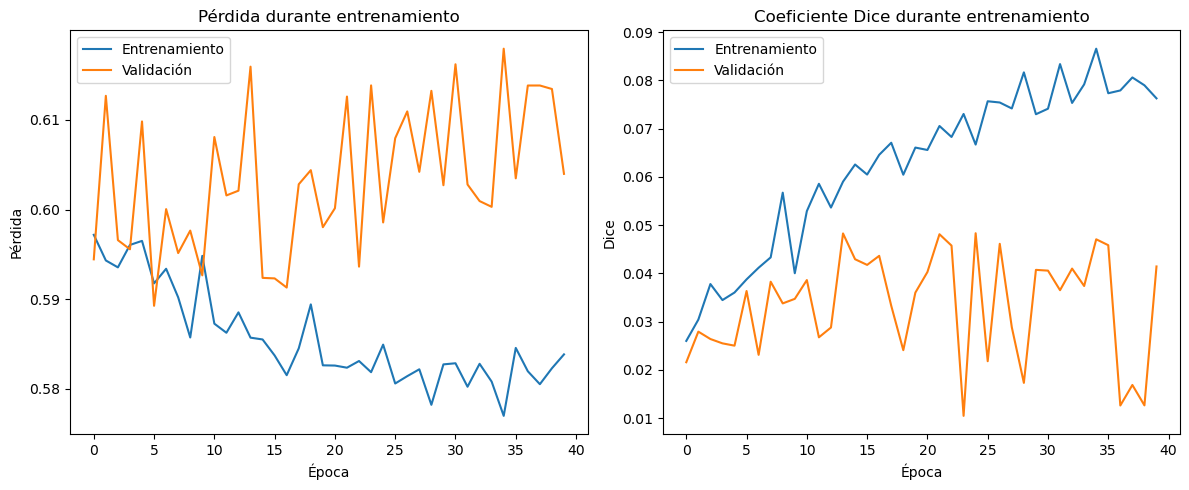

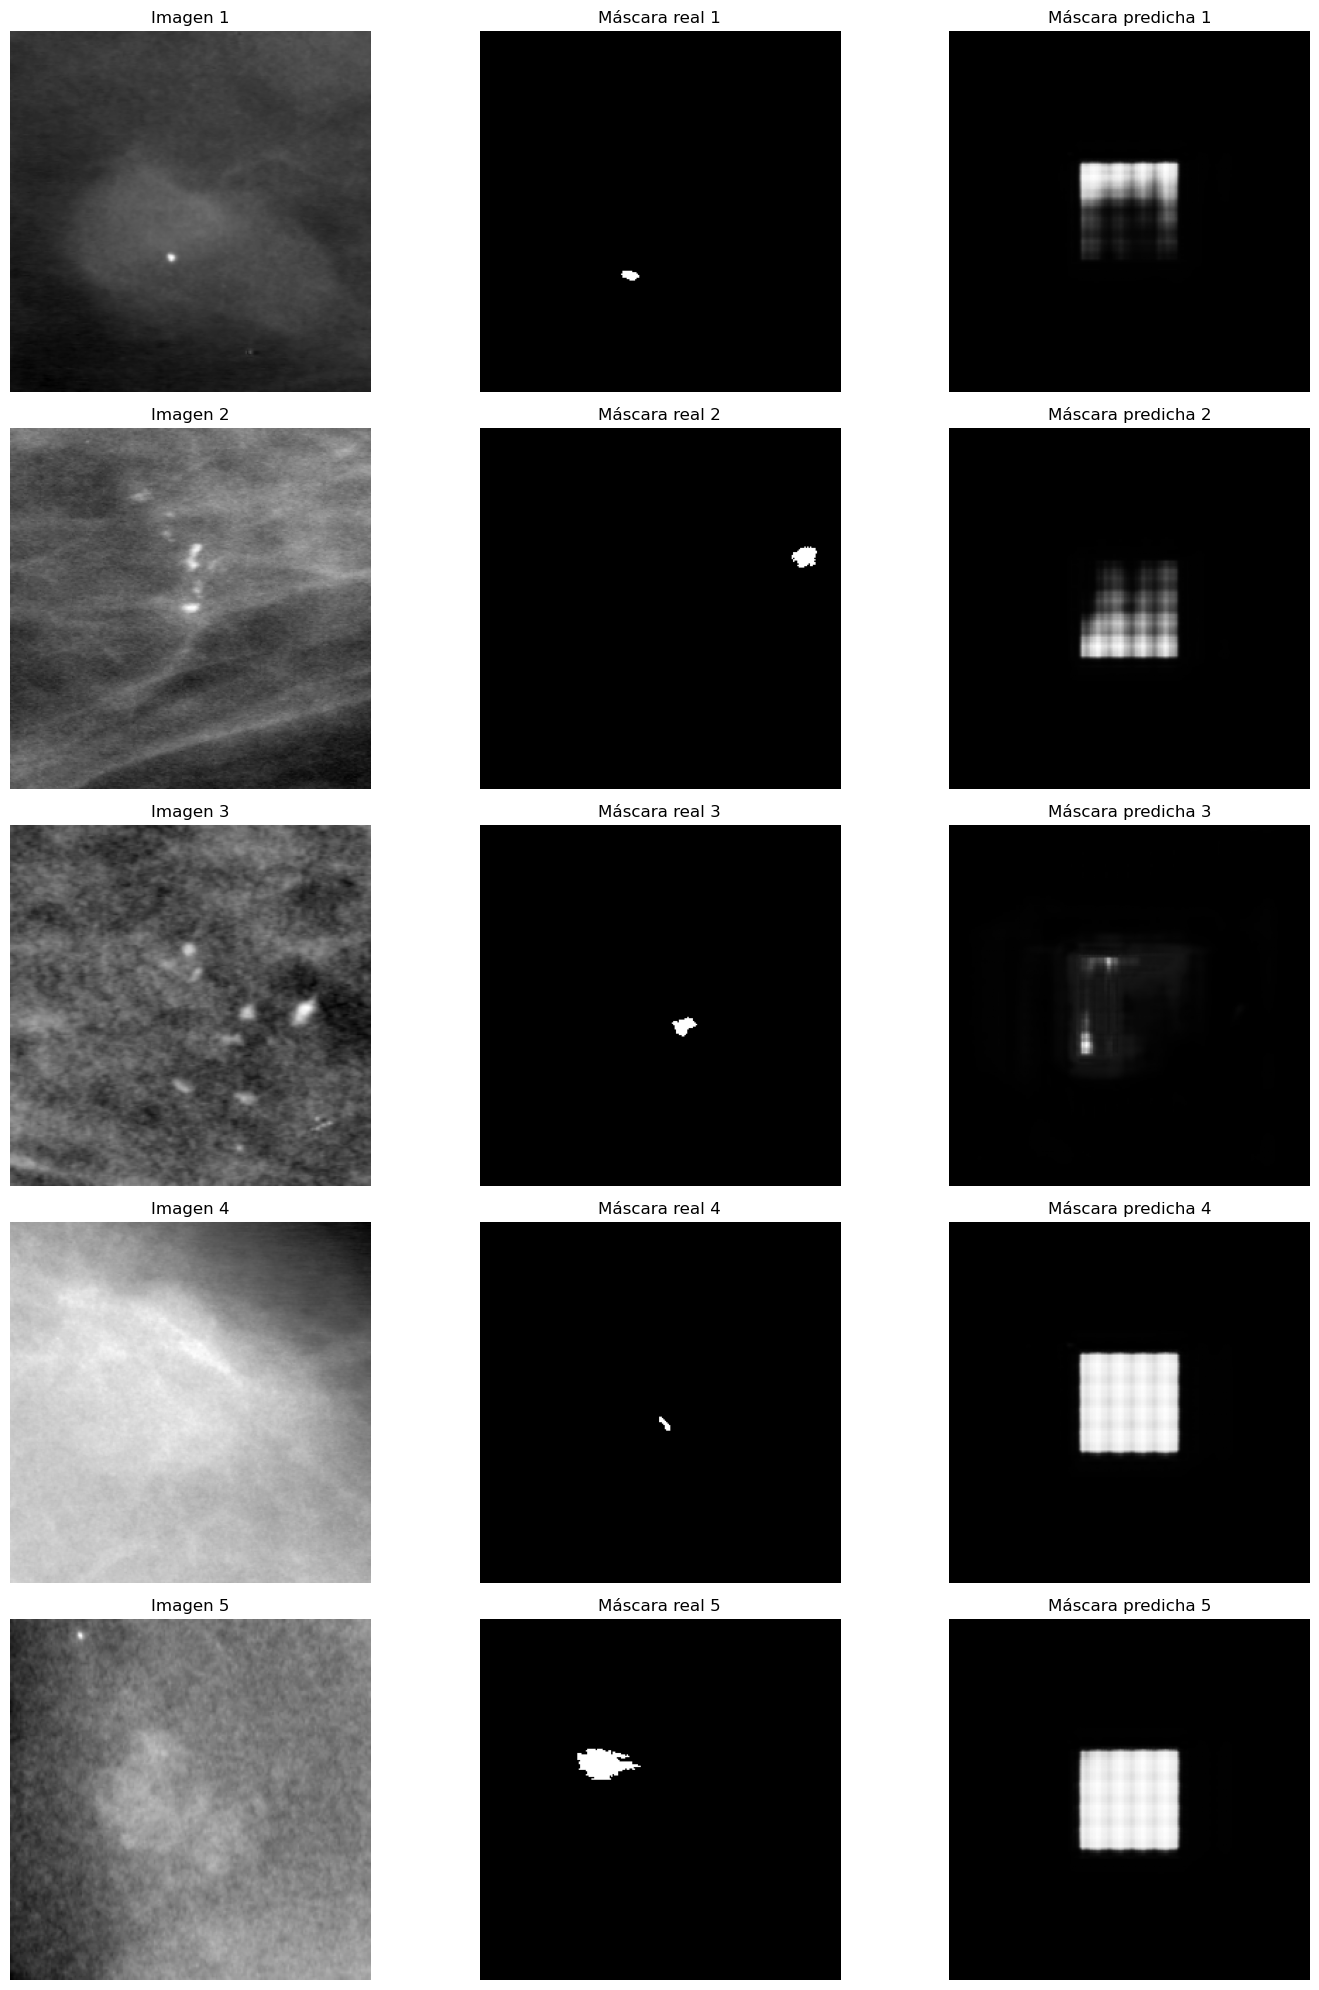

In [133]:
# Parámetros para el nuevo entrenamiento
IMG_SIZE = 256  # Tamaño óptimo para capturar detalles
BATCH_SIZE = 8  # Ajusta según la memoria de la GPU
EPOCHS = 50     # Entrena por más épocas
LEARNING_RATE = 1e-3  # Mayor tasa inicial

# Iniciar entrenamiento
print("Iniciando entrenamiento con configuración optimizada para mamografías...")
trained_model, history = train_model_enhanced(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=EPOCHS
)

# Evaluar y visualizar
print("Evaluando modelo final...")
final_dice = evaluate_model(trained_model, test_loader)
print(f"Dice final en test: {final_dice:.4f}")

# Visualizar resultados
plot_training_history(history)
visualize_predictions(trained_model, test_dataset, num_samples=5)